# Flight Analytics Data Lake
# Data Engineering Capstone Project

## Project Summary

The goal of this project was to:
- Create a **Spark datalake**.
- To be used **for further analysis** by data scientists and BIs
- Using **Airflow** and **Spark** (standalone, cluster or EMR)
- That can be **developed on-premise** (i.e. laptop with local Spark cluster), and then **easily migrated to the cloud**.
    - the key point is that the above can be easily done incrementally in an Agile way, with unit and integration tests, easily switching between a local environment and the cloud.
- Using the provided **immigration data sets**.
    - but with state temperatures rather than city temperatures (no good reason for this, I made a mistake here and have no time to backtrack, but it doesn't have any technical implications).

##### Main features:
- The rationale was to do development, and unit and integration testing, locally to reduce cloud costs and not overspend the Udacity allocated AWS budget.
    - The focus was on development, not on analysis, although much analysis was performed using Pandas.
- Migration to the cloud is performed by just changing environment and Airflow variables.

##### Achieved by:

- Abstracting and encapsulating all data sets by a bespoke **Datalake API** that I designed, unit and integration tested, and consistently used throughout so that data can be manipulated uniformly regardless of their location (local, hdfs or cloud, and even a mix of all these).
- Implementing and consistently applying the **Stage-Check-Exchange ETL pattern** (described in [Airflow Concepts](https://airflow.apache.org/docs/apache-airflow/1.10.2/concepts.html?highlight=branch%20operator) and used at [AirBnB](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-ii-47c4e7cbda71).

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [50]:
# Do all imports and installs here

import pandas as pd
import seaborn as sns

# Rather than directly manipulating datasets, I will demonstrate in this notebook 
# the Datalake API that I developed for this project.
#
# I have copied the requiered Datalake API source files to the workspace under 
# the ```datalake``` directory; the Datalake API used by both Airflow and Spark jobs 
# for the project's ETL.
#
# The Datalake API's location must first be added to the PYTHONPATH:
import os
os.environ['PYTHONPATH'] = '.:' + os.environ.get('PYTHONPATH', '')

# For the Datalake API to work, we must first create a Spark context:
!pip install findspark
import findspark
findspark.init()
# Import a Datalake API module to create a Spark Session that depends on the environment.
from datalake.utils import spark_helper  
# Also create a dummy AWS credentials file (not needed here but required):
! mkdir -p ~/.aws && echo '[default]\naws_access_key_id = AAA\naws_secret_access_key = AAA'> ~/.aws/credentials
# Create a Spark Context
spark_helper.get_spark()

# By abstracting data set access, the datalake API allows data sets to be manipulated
# in the same way regardless of their location; all that is required is to set an 
# environment variable, and this works consistently in the same way for a notebook like this,
# or for a Spark job both on-premise or in a AWS EMR step:
os.environ['DATALAKE_ROOT'] = '.'

# A STAGING_ROOT, for ETL staging, would have be set in the same fashion for ETL jobs.

# The datalake API assumes a consistent directory hierarchy, and raw files are assumed 
# to be placed in the ```$DATALAKE_ROOT/raw``` directory.
#
# Given that we would like to use the
# raw files already provided by Udacity with the workspace, this can be achived with:
!ln -s . raw

# Some Spark imports:
import pyspark.sql.functions as F

# Patch some Spark classes so that I can use a pandas-like ```pipe``` method:
import datalake.utils.pipe

# We are now ready to access all files in the notebook using the Datalake API.

ln: failed to create symbolic link 'raw/.': File exists


### Step 1: Scope the Project and Gather Data

#### Scope 

##### Explain what you plan to do in the project in more detail.

Although my main focus was technical, the intention is to center the analysis around individual flights, by aggregating flight passenger data, in order to further analyse flight routes.

##### What data do you use? 

I used the immigration data set provided by Udacity, with same small variations:
- I used state temperatures instead of city temperatures.
- I used a US state abbreviation and name dataset, to standardize these.

As for the immigration data, only the following entries are relevant for the analysis:
- Arrivals by air.
- Arrivals in the US 50 states, DF and territories. 

##### What does your end solution look like? 

A datalake is created in S3, with a flights fact file and the following dimensions:
- time
- route
- foreign visitor

##### What tools did you use? 

- **Pandas**: for EDA
    - Exploratory analysis and data cleaning.
- **Airflow**: with two data pipelines:
    - Initial ETL: ETL referrence tables and create star schema.
    - Incremental monthly ETL: ETL immigration SAS file to populate facts and dimensions.
- **AWS S3**: to store the raw data and the datalake
- **AWS EMR**: to execute the ETL Spark jobs, with HDFS as staging storage.
    - I used mostly the pyspark Spark API, sprinkled with some Spark SQL.
    - I also used Spark ML for clustering demographics and temperature data.

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

I used the data sets provided by Udacity:


Instead of using city temperatures, used state temperatures, from https://data.world/data-society/global-climate-change-data

In [52]:
# Read in the data here

# Datamodel API files encapsulate the datasets: their location, format, schema, options, etc:
from datalake.datamodel.files.raw_airports_file import RawAirportsFile
from datalake.datamodel.files.raw_demographics_file import RawDemographicsFile
from datalake.datamodel.files.raw_i94_data_dictionary_file import RawI94DataDictionaryFile
from datalake.datamodel.files.raw_temperatures_file import RawTemperaturesFile

# I would like to handle all data sets in a consistent manner, but there is no datamodel
# class for the immigration sample file.
#
# This can still be achieved by creating a Datamodel API file class for it on the fly:
from datalake.model.file_base import FileBase
class RawImmigrationSampleFile(FileBase):
    def __init__(self):
        super().__init__(
            'immigration_data_sample.csv',   # file name
            None,   # schema-on-read
            FileBase.raw,   # datalake area (raw, eda, curated, staging or production)
            format='csv',   # default is Parquet; the Datalake API is a layer on the Spark API
            options = {'header': 'true'}  # additional options are provided in a dictionary
            # By default, Datalake API files are not writable, to protect raw files;
            # otherwise set:
            # writable = True
    )

# I decided to use an additional data set for US states, which I have uploaded to
# this workspace:
from datalake.datamodel.files.raw_states_file import RawStatesFile

# Now read the data:
raw_airports = RawAirportsFile().read().toPandas()  # reads airport-codes_csv.csv
raw_demographics = RawDemographicsFile().read().toPandas() # reads us-cities-demographics.csv
raw_i94_data_dictionary = RawI94DataDictionaryFile().read().toPandas() #I94_SAS_Labels_Descriptions.SAS
raw_immigration = RawImmigrationSampleFile().read().toPandas() # reads immigration_data_sample.csv
raw_states = RawStatesFile().read().toPandas() # reads us-states-territories.csv
raw_temperatures = RawTemperaturesFile().read().toPandas() # GlobalLandTemperaturesByState.csv

In [29]:
# To easily see how a Datalake API file is configured, just do:
from pprint import pprint
pprint(RawAirportsFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawAirportsFile']},
 'checks': [],
 'coalesce': None,
 'datalake_root': None,
 'format': 'csv',
 'mode': 'append',
 'name': 'airport-codes_csv.csv',
 'options': {'header': 'true'},
 'partitions': None,
 'schema': StructType(List(StructField(ident,StringType,true),StructField(type,StringType,true),StructField(name,StringType,true),StructField(elevation_ft,StringType,true),StructField(continent,StringType,true),StructField(iso_country,StringType,true),StructField(iso_region,StringType,true),StructField(municipality,StringType,true),StructField(gps_code,StringType,true),StructField(iata_code,StringType,true),StructField(local_code,StringType,true),StructField(coordinates,StringType,true))),
 'staging_root': None,
 'writable': False}


In [30]:
raw_airports.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


In [31]:
pprint(RawDemographicsFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawDemographicsFile']},
 'checks': [],
 'coalesce': 1,
 'datalake_root': None,
 'format': 'csv',
 'mode': 'append',
 'name': 'us-cities-demographics.csv',
 'options': {'header': True, 'sep': ';'},
 'partitions': None,
 'schema': StructType(List(StructField(City,StringType,true),StructField(State,StringType,true),StructField(Median Age,StringType,true),StructField(Male Population,StringType,true),StructField(Female Population,StringType,true),StructField(Total Population,IntegerType,true),StructField(Number of Veterans,StringType,true),StructField(Foreign-born,StringType,true),StructField(Average Household Size,StringType,true),StructField(State Code,StringType,true),StructField(Race,StringType,true),StructField(Count,StringType,true))),
 'staging_root': None,
 'writable': False}


In [32]:
raw_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [33]:
pprint(RawI94DataDictionaryFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawI94DataDictionaryFile']},
 'checks': [],
 'coalesce': None,
 'datalake_root': None,
 'format': 'text',
 'mode': 'append',
 'name': 'I94_SAS_Labels_Descriptions.SAS',
 'options': None,
 'partitions': None,
 'schema': None,
 'staging_root': None,
 'writable': False}


In [34]:
# this may seem bizarre, but see below
raw_i94_data_dictionary.head()

,value
0,libname library 'Your file location' ;
1,proc format library=library ;
2,
3,/* I94YR - 4 digit year */
4,


In [35]:
pprint(RawImmigrationSampleFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawImmigrationSampleFile']},
 'checks': [],
 'coalesce': None,
 'datalake_root': None,
 'format': 'csv',
 'mode': 'append',
 'name': 'immigration_data_sample.csv',
 'options': {'header': 'true'},
 'partitions': None,
 'schema': None,
 'staging_root': None,
 'writable': False}


In [36]:
raw_immigration.head()

,_c0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,None,M,1955.0,07202016,F,None,JL,56582674633.0,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,None,M,1990.0,10222016,M,None,*GA,94361995930.0,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,None,M,1940.0,07052016,M,None,LH,55780468433.0,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,None,M,1991.0,10272016,M,None,QR,94789696030.0,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,None,M,1997.0,07042016,F,None,None,42322572633.0,LAND,WT


In [37]:
pprint(RawStatesFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawStatesFile']},
 'checks': [],
 'coalesce': None,
 'datalake_root': None,
 'format': 'csv',
 'mode': 'append',
 'name': 'us-states-territories.csv',
 'options': {'encoding': 'ISO-8859-1', 'header': 'true'},
 'partitions': None,
 'schema': StructType(List(StructField(Type,StringType,true),StructField(Name,StringType,true),StructField(Abbreviation,StringType,true),StructField(Capital,StringType,true),StructField(Population (2015),StringType,true),StructField(Population (2019),StringType,true),StructField(area (square miles),StringType,true))),
 'staging_root': None,
 'writable': False}


In [38]:
raw_states.head()

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles)
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420"
1,State,Alaska,AK,Juneau,None,"731,545","665,384"
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990"
3,State,Arkansas,AR,Little Rock,None,"3,017,804","53,179"
4,State,California,CA,Sacramento,None,"39,512,223","163,695"


In [39]:
pprint(RawTemperaturesFile().__dict__)

{'area': 'raw',
 'base_check': {'table': ['RawTemperaturesFile']},
 'checks': [],
 'coalesce': 1,
 'datalake_root': None,
 'format': 'csv',
 'mode': 'append',
 'name': 'GlobalLandTemperaturesByState.csv',
 'options': {'header': 'true'},
 'partitions': None,
 'schema': StructType(List(StructField(dt,DateType,true),StructField(AverageTemperature,DoubleType,true),StructField(AverageTemperatureUncertainty,StringType,true),StructField(State,StringType,true),StructField(Country,StringType,true))),
 'staging_root': None,
 'writable': False}


In [40]:
raw_temperatures.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [53]:
"""
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
"""

# SAS files can also be handled by the Datalake API:
from datalake.datamodel.files.sas_file import SasFile
!ln -s /data/18-83510-I94-Data-2016
april = SasFile('2016-04-01').read()

ln: failed to create symbolic link './18-83510-I94-Data-2016': File exists


In [42]:
pprint(SasFile('2016-04-01').__dict__)

{'area': 'raw',
 'base_check': {'table': ['SasFile']},
 'checks': [],
 'coalesce': None,
 'datalake_root': None,
 'format': 'com.github.saurfang.sas.spark',
 'mode': 'append',
 'name': '18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat',
 'options': None,
 'partitions': None,
 'schema': None,
 'staging_root': None,
 'writable': False}


In [43]:
april.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [ ]:
"""
I processed the SAS files in a different manner, see below

#write to parquet
df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")
"""

## Step 2: Explore and Assess the Data
### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Explore Immigration data

I will focus on exploring flights and their passengers, given that this is the project's goal.

This exploration will consist of the following steps:
- explore the immigration data dictionary
- filter out non-air arrivals
- filter out arrivals in non-US ports
    - this will require further ports exploration
- generate a more suitable sample, a random flight cluster sample

The first step will be to explore the immigration data dictionay, because otherwise we won't be to know what the values in some columns mean:

##### Explore the immigration data dictionary

This is the following file:

In [45]:
RawI94DataDictionaryFile().name

'I94_SAS_Labels_Descriptions.SAS'

Understanding this file is needed in order to make sense of the immigration data.

This file is, apparently, in an unstructured format, free text:

In [46]:
raw_i94_data_dictionary[:10]

,value
0,libname library 'Your file location' ;
1,proc format library=library ;
2,
3,/* I94YR - 4 digit year */
4,
5,/* I94MON - Numeric month */
6,
7,/* I94CIT & I94RES - This format shows all the...
8,value i94cntyl
9,"582 = 'MEXICO Air Sea, and Not Reported (I..."


However, although it not in any common format, it does have some structure.

Althought there are simpler ways for extracting the data from this file (like using ```sed```), I decided, as an exercise, to write a simple parser.
- I won't go into the details of the parser in this notebook, it is documented in the [parser's source code in Github](https://github.com/charlysl/de-capstone/blob/main/src/main/dags/i94_data_dictionary.py).

Lets now extract the data using the parser:

In [58]:
from dags.i94_data_dictionary import DataDictionaryParser, ListData
dict_file = RawI94DataDictionaryFile().name
parser = DataDictionaryParser(dict_file, output=ListData())
raw_dict = parser.parse(debug=False)

There are the following keys in the dictionary:

In [55]:
raw_dict.keys()

dict_keys(['I94CIT', 'I94PORT', 'I94MODE', 'I94ADDR', 'VISATYPE'])

- I94CIT
- I94PORT
- I94MODE
- I94ADDR
- VISATYPE

Let's explore them:

###### ```I94CIT```: Explore countries

Represents a mapping between the immigration ```i94cit``` (citizenship) and ```i94res``` (residence) columns and a country name:

In [59]:
raw_countries = pd.DataFrame(raw_dict['I94CIT'], columns=['country_id', 'country_name'])
raw_countries[:5]

,country_id,country_name
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


The are 289 countries, won't list them all in this notebook:

In [60]:
raw_countries.count()

country_id      289
country_name    289
dtype: int64

Visual inspection of all countries reveals the following invalid country name patterns:
- ```MEXICO Air Sea, and Not Reported (I-94, no land arrivals)```
- ```INVALID: AMERICAN SAMOA```
- ```Collapsed Tanzania (should not show)```
- ```No Country Code (54)```

There are no duplicate country codes:

In [61]:
def has_duplicates(df, col):
    return not (raw_countries[col].count() == raw_countries[col].drop_duplicates().count())

In [62]:
has_duplicates(raw_countries, 'country_id')

False

However, there are duplicate country names:

In [63]:
has_duplicates(raw_countries, 'country_name')

True

The following country names have duplicates:

In [64]:
def duplicates(df, col):
    dups = (df.groupby(col).count() > 1).reset_index()
    filt = dups.iloc[:,1]
    return dups[filt][col]

In [65]:
duplicates(raw_countries, 'country_name')

118        INVALID: STATELESS
120    INVALID: UNITED STATES
Name: country_name, dtype: object

###### ```I94PORT```: Explore ports

Represents a mapping between the immigration ```i94port``` column and immigration port names, which seem to consist by a city name and a state abbreviation, separated by a comma:

In [66]:
raw_ports = pd.DataFrame(raw_dict['I94PORT'], columns=['port_id', 'port_name'])
raw_ports[:5]

,port_id,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [67]:
len(raw_ports)

660

I will continue explore ports later on.

###### ```I94MODE```: Explore arrival mode

In [68]:
modes = pd.DataFrame(raw_dict['I94MODE'], columns=['mode_id', 'mode_name'])
modes

,mode_id,mode_name
0,1,Air
1,2,Sea
2,3,Land
3,9,Not reported


We are only interested in mode ``1, Air```.

###### ```I94ADDR```: Explore states

This represents the US states referred to by immigration column ```i94addr```.
- All US states and territories are included, albeit some with non-standard names (i.e. "N. DAKOTA")

In [69]:
raw_dict_states = pd.DataFrame(raw_dict['I94ADDR'], columns=['state_id', 'state_name'])
raw_dict_states

,state_id,state_name
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA
5,CO,COLORADO
6,CT,CONNECTICUT
7,DE,DELAWARE
8,DC,DIST. OF COLUMBIA
9,FL,FLORIDA


##### Prepare immigration data for exploration

The immigration data as is is not suitable for exploration; we want to first:

- remove irrelevant data
    - keep only arrivals by air
    - drop irrelevant columns
- generate a more suitable sample, a random flight cluster sample

All these steps will be performed on a month's worth of data.
- The reason is that we need to obtain a cluster sample of flights.
- But before sampling, we must weed out irrelevant data.

There are around 3 million arrivals in April:

In [70]:
april.count()

3096313

###### Remove irrelevant immigration data

Filter out non-air arrivals:

In [71]:
def filter_out_non_air_arrivals(df):
    return df.where(F.col('i94mode') == 1)

In [72]:
(
    april
    .pipe(filter_out_non_air_arrivals)
).count()

2994505

The bulk of arrivals was by air anyway, almost 3 million in April.

Drop immigration columns that are irrelevant to exploration

In [73]:
print(april.columns)

['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']


- also rename the remaining columns to make it easier to work with them
- In particular, we don't need year and month, given that we will be exploring data from just one month, and ```i94mode```, given that arrival mode is by air only.
- But leave ```cicid``` (maybe useful as id) and ```count``` (maybe useful for aggregates)
- Columns will be dropped because:

- they are irrelevant (```dtadfile```, ```visapost```, ```entdepa```, ```entdepd```, ```entdepu```, ```matflag```, ```biryear```, ```dtaddto```, ```insnum```, ```admnum```)

- their values' meaning isn't clear(```visatype```, I search online, couldn't find a good source)

In [74]:
april.select('visatype').dropDuplicates().toPandas()

,visatype
0,CPL
1,GMT
2,WB
3,E2
4,GMB
5,I
6,F2
7,E1
8,M1
9,I1


- they are mostly null (```occup```)

In [75]:
april.where(F.expr('occup IS NULL')).count()

3088187

The ```arrdate``` and ```depdate``` immigration columns are in SAS data formate, which is the number of days since the 1st of January of 1960.

The following function performs the conversion to regular dates:

In [76]:
def from_sas_date(col):
    return F.expr("date_add('1960-01-01', %s)" % col)

Now we can drop and rename immigration columns:

In [77]:
def drop_immigration_columns(df):
    return (
            df.select(
            'airline',
            F.col('fltno').alias('flight_number'),
            F.col('i94port').alias('port_id'),
            from_sas_date('arrdate').alias('arrival'),
            from_sas_date('depdate').alias('departure'),
            F.col('i94cit').alias('citizenship'),
            F.col('i94res').alias('residence'),
            F.col('i94bir').alias('age'),
            'gender',
            F.col('i94addr').alias('address_state'),
            F.col('i94visa').alias('visa'),
            F.col('cicid').alias('id'),
            'count'
        )
    )

In [78]:
(
    april
    .pipe(filter_out_non_air_arrivals)
    .pipe(drop_immigration_columns)
).limit(5).toPandas()

,airline,flight_number,port_id,arrival,departure,citizenship,residence,age,gender,address_state,visa,id,count
0,None,00296,ATL,2016-04-07,None,254.0,276.0,25.0,M,AL,3.0,7.0,1.0
1,OS,93,WAS,2016-04-01,2016-08-25,101.0,101.0,55.0,M,MI,2.0,15.0,1.0
2,AA,00199,NYC,2016-04-01,2016-04-23,101.0,101.0,28.0,None,MA,2.0,16.0,1.0
3,AA,00199,NYC,2016-04-01,2016-04-23,101.0,101.0,4.0,None,MA,2.0,17.0,1.0
4,AZ,00602,NYC,2016-04-01,2016-04-11,101.0,101.0,57.0,None,MI,1.0,18.0,1.0


###### generate a more suitable sample, a random flight cluster sample

In order to do this, we must first group the immigration data by flight.

An individual flight can be identified by its airline, flight number and arrival date.

So, in fact, that is the natural key for a flight:

In [79]:
def get_flights(df):
    return (
        df
        .select('airline', 'flight_number', 'arrival')
        .dropDuplicates()
    )

In [80]:
(
    april
    .pipe(filter_out_non_air_arrivals)
    .pipe(drop_immigration_columns)
    .pipe(get_flights)
).count()

90805

We want a sample of around 1000 passengers
- A quick calculation: ~3M passenger, ~100K flights => ~30 foreign passengers/flight
- On average, we would need to sample ~30 flight; lets sample 40 to be sure
- that would be a fraction of 1/2500

In [81]:
def sample_flights(df):
    return df.sample(fraction=1/2500, seed=0)

In [82]:
sampled_flights = (
    april
    .pipe(filter_out_non_air_arrivals)
    .pipe(drop_immigration_columns)
    .pipe(get_flights)
    .pipe(sample_flights)
)
sampled_flights.toPandas()

,airline,flight_number,arrival
0,SU,110,2016-04-08
1,WS,01512,2016-04-09
2,G7,06212,2016-04-13
3,AA,00916,2016-04-13
4,AA,01053,2016-04-17
5,AC,00770,2016-04-19
6,AB,07450,2016-04-22
7,TN,00002,2016-04-01
8,JL,62,2016-04-11
9,AM,00416,2016-04-13


Lets now see if the sampled flights carry between them ~1000 foreign passengers:

In [83]:
flight_nk = ['airline', 'flight_number', 'arrival']

def merge_immigration_with_flights(df, flights):
    f = flights.select(
        F.col('airline').alias('f_airline'),
        F.col('flight_number').alias('f_flight_number'),
        F.col('arrival').alias('f_arrival'),
    )
    return df.join(
        f,
        on=(df['airline'] == f['f_airline']) 
            & (df['flight_number'] == f['f_flight_number'])
            & (df['arrival'] == f['f_arrival']),
        how='inner'
    ).drop('f_airline', 'f_flight_number', 'f_arrival')

In [84]:
raw_sample = (
    april
    .pipe(filter_out_non_air_arrivals)
    .pipe(drop_immigration_columns)
    .pipe(merge_immigration_with_flights, sampled_flights)
).toPandas()

Indeed, the sample passenger number is in the ballpark:

In [85]:
len(raw_sample)

1554

So now we have a suitable sample to explore immigration data.

In [93]:
raw_sample

,airline,flight_number,port_id,arrival,departure,citizenship,residence,age,gender,address_state,visa,id,count
0,AA,00916,MIA,2016-04-13,2016-04-17,117.0,117.0,85.0,F,FL,2.0,2316290.0,1.0
1,AA,00916,LOS,2016-04-13,2016-04-14,129.0,687.0,51.0,M,FL,1.0,2322593.0,1.0
2,AA,00916,MIA,2016-04-13,2016-04-17,520.0,520.0,62.0,F,FL,2.0,2385374.0,1.0
3,AA,00916,MIA,2016-04-13,None,691.0,691.0,60.0,F,FL,2.0,2473292.0,1.0
4,AA,00916,MIA,2016-04-13,2016-08-10,691.0,691.0,67.0,F,FL,2.0,2473328.0,1.0
5,AA,00916,MIA,2016-04-13,2016-04-16,691.0,691.0,49.0,M,FL,1.0,2473353.0,1.0
6,AA,00916,MIA,2016-04-13,2016-04-17,691.0,691.0,61.0,M,FL,2.0,2473393.0,1.0
7,AA,00916,MIA,2016-04-13,2016-04-17,691.0,691.0,56.0,F,FL,2.0,2473402.0,1.0
8,AA,00916,MIA,2016-04-13,2016-04-17,691.0,691.0,53.0,F,FL,2.0,2473406.0,1.0
9,AA,00916,MIA,2016-04-13,2016-04-17,691.0,691.0,51.0,F,FL,2.0,2473408.0,1.0


Lets assess missing values in the sample for each column:

In [94]:
def col_has_nulls(df, col):
    return len(df[col].isnull().value_counts()) > 1

In [95]:
def null_cols(df):
    return pd.DataFrame({
        'column': df.columns,
        'has_nulls': [df.pipe(col_has_nulls, col) for col in df.columns]
    })
        

In [96]:
def nulls_proportion(df, cols=None):
    cols = cols if cols else df.columns
    props = pd.DataFrame({
        'column': cols,
        '% nulls': [100 * len(df[df[col].isnull()]) / len(df) for col in cols]
    })
    return props[props['% nulls'] > 0]

In the sample, the following columns have nulls:
- departure (presumably foreign visitors that are still in the country)
- gender
- citizenship
- address_state

In [97]:
raw_sample.pipe(nulls_proportion)

,column,% nulls
4,departure,2.574003
8,gender,12.998713
9,address_state,1.608752


In [98]:
[col for col in ['departure', 'gender', 'citizenship', 'address_state']]

['departure', 'gender', 'citizenship', 'address_state']

Lets now examine the ranges for each numerical column in the sample.

The only actual numerical column here is ```age```, and the values seem within range:

In [99]:
raw_sample.describe()

,citizenship,residence,age,visa,id,count
count,1554.000000,1554.000000,1554.000000,1554.000000,1.554000e+03,1554.0
mean,198.023166,185.763835,44.234234,1.785714,3.598589e+06,1.0
std,141.497281,134.010188,15.984151,0.430369,1.487620e+06,0.0
min,103.000000,103.000000,1.000000,1.000000,3.260000e+02,1.0
25%,123.000000,112.000000,33.000000,2.000000,3.085331e+06,1.0
50%,148.000000,130.000000,45.000000,2.000000,4.049931e+06,1.0
75%,209.000000,209.000000,55.000000,2.000000,4.906158e+06,1.0
max,756.000000,691.000000,89.000000,3.000000,5.755720e+06,1.0


Lets see the distribution for each column in the sample:
- wont' do it for arrival and departure dates, because, given that we have about as many sample flights as days in the month, it wouldn't make sense, every day will receive on average one flight, but that flight might carry many or just a few foreign passengers.

In [100]:
raw_sample.columns

Index(['airline', 'flight_number', 'port_id', 'arrival', 'departure',
       'citizenship', 'residence', 'age', 'gender', 'address_state', 'visa',
       'id', 'count'],
      dtype='object')

In [101]:
def plot_category(df, col):
    data = (
        df
        [col]
        .value_counts()
        .reset_index()
        .rename(columns={
            col: 'count',
            'index': col
        })
        .sort_values('count')
    )
    sns.set(rc={'figure.figsize':(8,6)})
    sns.barplot(
        x=col,
        y='count',
        data=data,
    );
    sns.set()

Airline foreign passenger numbers seem to follow a power law:

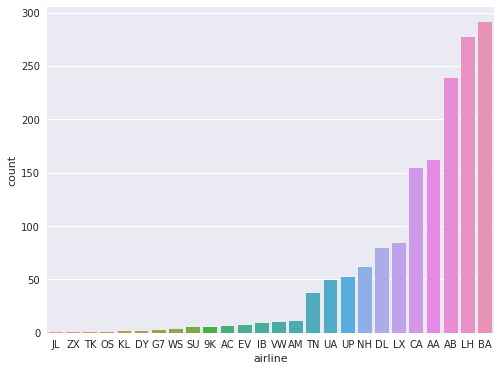

In [103]:
plot_category(raw_sample, 'airline')

Immigration ports (which represent destination airports, and, hence, cities), also seem to follow a power law, judging form the sample.

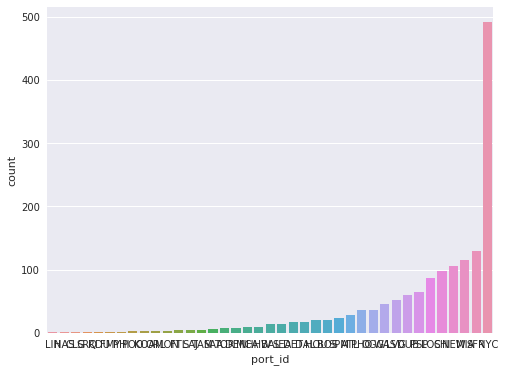

In [104]:
plot_category(raw_sample, 'port_id')

Again, citizenship and residence also seem to follow a power law:

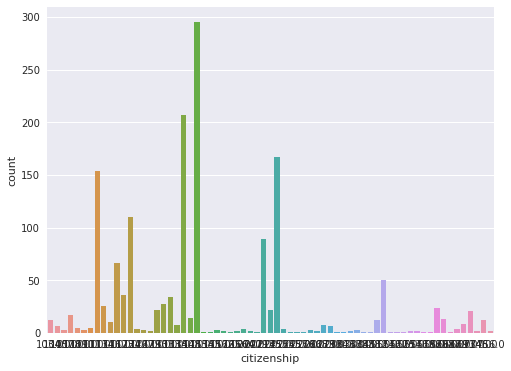

In [105]:
plot_category(raw_sample, 'citizenship')

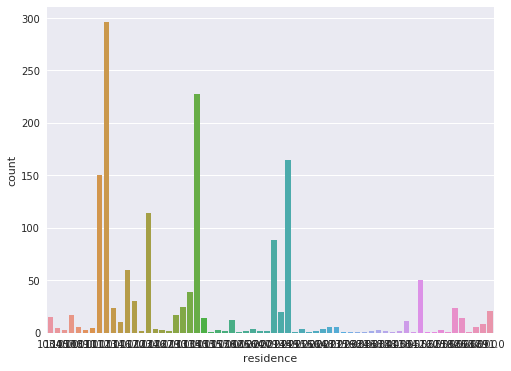

In [106]:
plot_category(raw_sample, 'residence')

Age, on the other hands, seems like a normal distribution.

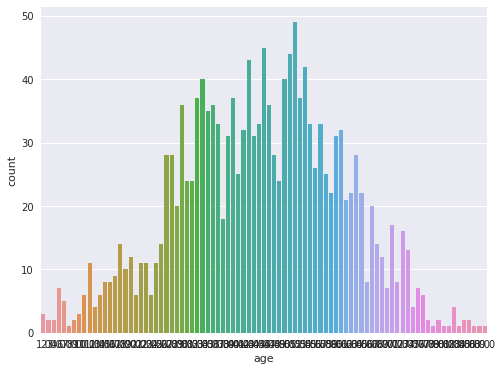

In [107]:
plot_category(raw_sample, 'age')

Foreign visitors address states also seem to follow a power law:

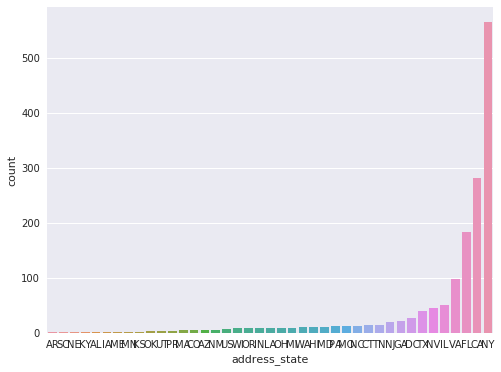

In [108]:
plot_category(raw_sample, 'address_state')

Most visitors seem to be tourists, and just a few, students:

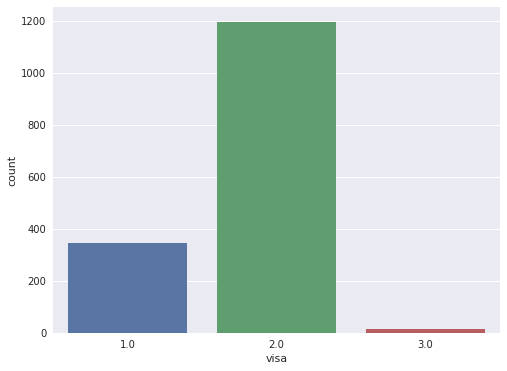

In [109]:
plot_category(raw_sample, 'visa')

##### Explore ports

Port id mappings to location were already extracted from the immigration data dictionary:

In [110]:
raw_ports[:5]

,port_id,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


From the port_name we can tell that port names, although unstructured,  seem to follow a pattern, where a city name is separated from a state abbreviation by a comma.

In [111]:
def strip_port_name(df):
    return df.assign(port_name=df['port_name'].str.strip())

In [112]:
def has_state_suffix(df):
    return df['port_name'].str[-4:].str.contains(r', ?[A-Z]{2}')

However, it seems that there are over 150 ports that don't follow this format:

In [113]:
(
    raw_ports
    .pipe(strip_port_name)
    .pipe(has_state_suffix)
).value_counts()

True     508
False    152
Name: port_name, dtype: int64

In [117]:
raw_ports_with_state_suffix = (
    raw_ports
    .pipe(strip_port_name)[
        raw_ports
        .pipe(strip_port_name)
        .pipe(has_state_suffix)
    ]
)

In [118]:
def extract_port_state(df):
    return df['port_name'].str[-2:]

The number of different port states, for those that follow the standard format, seems right:

In [119]:
port_states = (
    raw_ports_with_state_suffix
    .pipe(extract_port_state)
    .drop_duplicates()
    .to_frame()
    .rename(columns={'port_name': 'state_id'})
)

In [120]:
len(port_states)

54

We will have to merge with state abbreviations to be sure:

In [121]:
def merge_ports_with_states(df, states):
    return df.merge(states, left_on='state_id', right_on='state_id', how='left')

All state abbreviations in this case, are standard, except for MX:

In [122]:
(
    port_states
    .pipe(merge_ports_with_states, raw_dict_states)
)

,state_id,state_name
0,AK,ALASKA
1,AL,ALABAMA
2,AR,ARKANSAS
3,AZ,ARIZONA
4,CA,CALIFORNIA
5,CO,COLORADO
6,CT,CONNECTICUT
7,DE,DELAWARE
8,FL,FLORIDA
9,GA,GEORGIA


As for the ports that don't follow the standard format, they come in different formats, and some can be fixed, but others, can't:

RECOVERABLE

Linked to other port
- 591	FRG	Collapsed (FOK) 06/15

2 letter state in another format
- 24	LIA	LITTLE ROCK, AR (BPS)
- 28	MAP	MARIPOSA AZ
- 76	WAS	WASHINGTON DC
- 65	ASE	ASPEN, CO #ARPT
- 428	PDN	PASO DEL NORTE,TX
- 462	DER	DERBY LINE, VT (I-91)
- 463	DLV	DERBY LINE, VT (RT. 5)
- 473	SWB	SWANTON, VT (BP - SECTOR HQ)

state name
- 478	BLI	BELLINGHAM, WASHINGTON #INTL

3 letter state
- 387	SAI	SAIPAN, SPN

NOT USA

Other countries (can include MX "state" above)
- 519	CLG	CALGARY, CANADA
- 522	HAL	Halifax, NS, Canada
- 531	ARB	ARUBA, NETH ANTILLES
- 560	NCA	NORTH CAICOS, TURK & CAIMAN
- 578	MAA	Abu Dhabi


UNRECOVERABLE
- 206	INT	INT
- 516	XXX	NOT REPORTED/UNKNOWN
- 517	888	UNIDENTIFED AIR / SEAPORT
- 518	UNK	UNKNOWN POE
- 575	ZZZ	MEXICO Land (Banco de Mexico)
- 601	PHF	No PORT Code (PHF)

##### Explore Countries

Country mappings to immigration were also extracted from the immigration data dictionary:

In [123]:
raw_countries[:5]

,country_id,country_name
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


It is immediatly apparent that Mexico should be fixed.

Lets start by checking if there are any duplicate country names:

In [124]:
duplicates(raw_countries, 'country_name')

118        INVALID: STATELESS
120    INVALID: UNITED STATES
Name: country_name, dtype: object

So, not only are these duplicates, but also invalid.

Moreover, a visual inspection of country names shows that some are clearly invalid, and they follow a pattern, deductible from the following examples:

```
INVALID: BORN ON BOARD SHIP
Collapsed Tanzania (should not show)
No Country Code (100)
```

##### Explore Airports

In [125]:
raw_airports[:5]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


We are interested in just US and territories airports, which can be filtered based on the ```iso_country``` column:

In [126]:
iso_countries = ['US', 'AS', 'FM', 'GU', 'MH', 'MP', 'PR', 'PW', 'VI']

- It seems possible to extract the airport's state from the ```iso_region``` column.
- The ```municipality``` column seems to be a city name.
- The ```coordinates``` column seems useful for map vizualization.

Before be assess data quality, lets drop irrelevant columns and airports not in US or territories:

In [127]:
def project_raw_airports(df):
    return (
        df
        [['ident', 'type', 'name', 'iso_country', 'iso_region', 'municipality',
         'iata_code', 'coordinates']]
    )

In [128]:
def drop_non_US_airports(df):
    return df[df['iso_country'].isin(iso_countries)]

In [129]:
raw_us_airports = (
    raw_airports
    .pipe(project_raw_airports)
    .pipe(drop_non_US_airports)
)
raw_us_airports[:5]

,ident,type,name,iso_country,iso_region,municipality,iata_code,coordinates
0,00A,heliport,Total Rf Heliport,US,US-PA,Bensalem,None,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,US,US-KS,Leoti,None,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,US,US-AK,Anchor Point,None,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,US,US-AL,Harvest,None,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,US,US-AR,Newport,None,"-91.254898, 35.6087"


In [130]:
len(raw_us_airports)

22892

Lets start assessing data quality by identifying which columns have nulls:

In [131]:
raw_us_airports.pipe(nulls_proportion)

,column,% nulls
5,municipality,0.449939
6,iata_code,90.887646


This makes sense, given that only international airports have an IATA code.

Assuming internatinal airports are more likely to be large, lets see what proportion of large airports have a null IATA code:

In [132]:
raw_us_airports['type'].drop_duplicates()

0              heliport
1         small_airport
4                closed
36        seaplane_base
1332        balloonport
6188     medium_airport
26007     large_airport
Name: type, dtype: object

In [133]:
(
    raw_us_airports
    [raw_us_airports['type'] == 'large_airport']
    .pipe(nulls_proportion)
)

,column,% nulls
5,municipality,1.156069
6,iata_code,2.312139


As expected, very few large airports are not international.

It would also make sense to get rid of airports of type 'closed'.

##### Explore Demographics

In [134]:
raw_demographics[:5]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


For each city there a row per race:

In [135]:
raw_demographics[raw_demographics['City'] == 'New York']

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
1826,New York,New York,36.0,4081698,4468707,8550405,156961,3212500,2.68,NY,White,3835726
2225,New York,New York,36.0,4081698,4468707,8550405,156961,3212500,2.68,NY,Asian,1304564
2304,New York,New York,36.0,4081698,4468707,8550405,156961,3212500,2.68,NY,American Indian and Alaska Native,90923
2493,New York,New York,36.0,4081698,4468707,8550405,156961,3212500,2.68,NY,Hispanic or Latino,2485125
2494,New York,New York,36.0,4081698,4468707,8550405,156961,3212500,2.68,NY,Black or African-American,2192248


Not all cities have all races:

In [136]:
raw_demographics[raw_demographics['City'] == 'The Villages']

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
333,The Villages,Florida,70.5,None,None,72590,15231,4034,None,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,None,None,72590,15231,4034,None,FL,Black or African-American,331
1437,The Villages,Florida,70.5,None,None,72590,15231,4034,None,FL,White,72211


Lets assess data quality, starging with nulls:

In [137]:
raw_demographics.pipe(nulls_proportion)

,column,% nulls
3,Male Population,0.103770
4,Female Population,0.103770
6,Number of Veterans,0.449671
7,Foreign-born,0.449671
8,Average Household Size,0.553442


The most relevant columns (city, state, race and count) dont't have any nulls.

Let's see if all states and territories are covered:

In [138]:
len(raw_demographics['State'].drop_duplicates())

49

In [139]:
raw_demographics['State'].drop_duplicates().sort_values()

2                   Alabama
235                  Alaska
6                   Arizona
38                 Arkansas
3                California
26                 Colorado
29              Connecticut
177                Delaware
136    District of Columbia
15                  Florida
53                  Georgia
296                  Hawaii
186                   Idaho
5                  Illinois
207                 Indiana
99                     Iowa
13                   Kansas
73                 Kentucky
96                Louisiana
530                   Maine
0                  Maryland
1             Massachusetts
28                 Michigan
30                Minnesota
244             Mississippi
8                  Missouri
590                 Montana
54                 Nebraska
24                   Nevada
169           New Hampshire
4                New Jersey
97               New Mexico
48                 New York
9            North Carolina
174            North Dakota
182                 

The best way to asses which states are missing in demographics would be to merge with a complete set of state names.
- Unfortunately, the state names in the immigration data dictionary are non-standard
- For this reason, I decided to download a better state names data set:

In [140]:
raw_states

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles)
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420"
1,State,Alaska,AK,Juneau,None,"731,545","665,384"
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990"
3,State,Arkansas,AR,Little Rock,None,"3,017,804","53,179"
4,State,California,CA,Sacramento,None,"39,512,223","163,695"
5,State,Colorado,CO,Denver,None,"5,758,736","104,094"
6,State,Connecticut,CT,Hartford,None,"3,565,278","5,543"
7,State,Delaware,DE,Dover,None,"973,764","2,489"
8,State,Florida,FL,Tallahassee,None,"21,477,737","65,758"
9,State,Georgia,GA,Atlanta,None,"10,617,423","59,425"


However there is a small oddity we have to fix first: some state names have an "[E]" suffix:

In [141]:
def remove_brackets_suffix(df):
    return df.assign(state_name=df['Name'].str.replace(
                                                        regex=True, 
                                                        pat='^(.+)\[.+$', 
                                                        repl=lambda match: match.group(1)
                                                        ).str.strip()
    )

In [142]:
raw_fixed_states = (
    raw_states
    .pipe(remove_brackets_suffix)
    .drop(['Name'], axis=1)
)

Now we can assess which states are missing demographic information:

In [143]:
(
    set(raw_fixed_states['state_name'].values)
    -
    set(raw_demographics['State'].drop_duplicates())
)

{'American Samoa',
 'Baker Island',
 'Guam',
 'Howland Island',
 'Jarvis Island',
 'Johnston Atoll',
 'Kingman Reef',
 'Midway Atoll',
 'Navassa Island',
 'Northern Mariana Islands',
 'Palmyra Atoll',
 'U.S. Virgin Islands',
 'Vermont',
 'Wake Island',
 'West Virginia',
 'Wyoming'}

Of the relevant states, the ones missing demographics for any cities are:
- Vermont
- West Virginia
- Wyoming

##### Explore State Temperatures

In [144]:
raw_temperatures[:5]

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


We are only interested in USA temperatures:

In [145]:
def only_us_temperatures(df):
    return df[df['Country'] == 'United States']

Moreover, we are not interested in the uncertainty, and now the country is always US:

In [146]:
def project_temperatures(df):
    return df.drop(['AverageTemperatureUncertainty', 'Country'], axis=1)

In [147]:
raw_us_temperatures = (
    raw_temperatures
    .pipe(only_us_temperatures)
    .pipe(project_temperatures)
)

Lets assess value ranges; the temperatures seem within reasonable values:

In [148]:
raw_us_temperatures.describe()

,AverageTemperature
count,141930.000000
mean,10.701555
std,10.225132
min,-28.788000
25%,2.995250
50%,11.516000
75%,19.274000
max,32.905000


Lets also assess date ranges:

In [149]:
raw_us_temperatures['dt'].max()

datetime.date(2013, 9, 1)

The most recent year for which temperatures are available is 2013, and is not complete, only until September.

Lets now assess if temperatures are avalilable for all states:

In [150]:
(
    set(raw_fixed_states['state_name'])
    -
    set(raw_us_temperatures['State'].drop_duplicates())
)

{'American Samoa',
 'Baker Island',
 'District of Columbia',
 'Georgia',
 'Guam',
 'Howland Island',
 'Jarvis Island',
 'Johnston Atoll',
 'Kingman Reef',
 'Midway Atoll',
 'Navassa Island',
 'Northern Mariana Islands',
 'Palmyra Atoll',
 'Puerto Rico',
 'U.S. Virgin Islands',
 'Wake Island'}

There seem to be no temperatures for the following relevat states and territories:
- District of Columbia
- Georgia
- Puerto Rico
- Virgin Islands

Having a closer look there are indeed temperatures for DF and Georgia, it is just that their names need fixing:

In [151]:
raw_us_temperatures['State'].drop_duplicates()

7458                   Alabama
12878                   Alaska
32008                  Arizona
34153                 Arkansas
71058               California
96604                 Colorado
98929              Connecticut
110201                Delaware
116053    District Of Columbia
123791                 Florida
131421         Georgia (State)
153157                  Hawaii
167979                   Idaho
170282                Illinois
173521                 Indiana
179567                    Iowa
214108                  Kansas
228059                Kentucky
276390               Louisiana
286896                   Maine
298686                Maryland
301925           Massachusetts
312139                Michigan
317559               Minnesota
320798             Mississippi
323865                Missouri
329717                 Montana
347985                Nebraska
356483                  Nevada
361946           New Hampshire
365185              New Jersey
368424              New Mexico
372822  

Lets end temperatures assessment by checking that complete temperatures are available for the most recent complete year, 2012:

In [152]:
raw_us_temperatures['dt'].apply(lambda dt: dt.year)

7458      1743
7459      1743
7460      1744
7461      1744
7462      1744
7463      1744
7464      1744
7465      1744
7466      1744
7467      1744
7468      1744
7469      1744
7470      1744
7471      1744
7472      1745
7473      1745
7474      1745
7475      1745
7476      1745
7477      1745
7478      1745
7479      1745
7480      1745
7481      1745
7482      1745
7483      1745
7484      1746
7485      1746
7486      1746
7487      1746
          ... 
626410    2011
626411    2011
626412    2011
626413    2011
626414    2011
626415    2011
626416    2011
626417    2011
626418    2011
626419    2012
626420    2012
626421    2012
626422    2012
626423    2012
626424    2012
626425    2012
626426    2012
626427    2012
626428    2012
626429    2012
626430    2012
626431    2013
626432    2013
626433    2013
626434    2013
626435    2013
626436    2013
626437    2013
626438    2013
626439    2013
Name: dt, Length: 149745, dtype: int64

In [ ]:
(
    raw_us_temperatures
    [raw_us_temperatures['dt'].apply(lambda dt: dt.year) == 2012]
    .shape[0]
)

This is exactly 12 months worth of records for the 50 states and DF:

In [153]:
51 * 12

612

### Cleaning Steps

For every data set, I will first paste the cleaning code, and then explain what it does step by step, and how it affects the data.
- Again, all interactions with the data sets are via the Datalake API
- The code in every script is structured in the same way, a set of functions that can be executed in a pipeline.
- With the exception of preprocessing the Immigration data dictionary, all cleaning scripts are meant to be executed in ETL as Spark jobs; in particular, they are executed by Spark from this notebook
- Again, with the exception just mentioned (which outputs a JSON file), all cleaning scripts output a Parquet file
- For the sake of this notebook, all clearning scripts will save their output in the datalake's curated area (which is the ```curated``` directory in the workspace). However, when executed as a Spark job during ETL, they will be saved in the staging area.
- In the project's github repo, all cleaning scripts are in the [src/main/etl_spark_jobs](https://github.com/charlysl/de-capstone/tree/main/src/main/etl_spark_jobs) directory.

Before we can execute the code, though, we need to configure the location of the staging area:

In [154]:
os.environ['STAGING_ROOT'] = './staging'

#### Cleaning States

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_states.py).

In [155]:
import pyspark.sql.functions as F

from datalake.datamodel.files.raw_states_file import RawStatesFile
from datalake.datamodel.files.states_file import StatesFile


def load_raw_states():
    return RawStatesFile().read()

def filter_missing_state_id(df):
    """
    Description: filter out those "states" that have no abbreviation
    """
    return (
        df
        .filter(F.col('Abbreviation').isNotNull())
    )

def clean_state_id(df):
    return df.withColumn('state_id', F.expr('TRIM(Abbreviation)'))

def clean_name(df):
    """
    Description: some state names have a "[E]" suffix; remove it
    """
    return df.withColumn('name', F.expr("""
        IF(
            SUBSTR(TRIM(Name), -1) = ']', 
            SUBSTRING_INDEX(TRIM(Name), '[', 1), 
            TRIM(Name)
        )
        """))

def clean_type_id(df):
    return df.withColumn('type_id', F.expr("""
          CASE TRIM(Type)
            WHEN 'State' THEN 0 
            WHEN 'Federal District' THEN 1
            WHEN 'Territory' THEN 2
          END
          """)
    )

def clean_type(df):
    return df.withColumn('type', F.expr('TRIM(Type)'))

def project_schema(df):
    """
    Description: select only the required columns
    """
    return df.select('state_id', 'name', 'type_id', 'type')

def save_clean_states(df):
    StatesFile().stage(df)
    # For notebook presentation, save also in curated area, so that
    # it can be serve as input to downstream scripts
    StatesFile().save(df)

def clean_states():
    """
    Description: Spark job that cleans raw US states.

    Prerequisites: a states file exists in raw datalake area.

    Effects: a states file created in curated datalake area that:
    - has 50 states, 1 federal district and the 6 main territories
    """
    return (
        load_raw_states()
        .pipe(filter_missing_state_id)
        .pipe(clean_state_id)
        .pipe(clean_name)
        .pipe(clean_type_id)
        .pipe(clean_type)
        .pipe(project_schema)
        .pipe(save_clean_states)
)


#clean_states()

##### Cleaning States: Step 0 - Read states source data set

In [156]:
(
    load_raw_states()
    #.pipe(filter_missing_state_id)
    #.pipe(clean_state_id)
    #.pipe(clean_name)
    #.pipe(clean_type_id)
    #.pipe(clean_type)
    #.pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles)
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420"
1,State,Alaska,AK,Juneau,None,"731,545","665,384"
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990"
3,State,Arkansas,AR,Little Rock,None,"3,017,804","53,179"
4,State,California,CA,Sacramento,None,"39,512,223","163,695"
5,State,Colorado,CO,Denver,None,"5,758,736","104,094"
6,State,Connecticut,CT,Hartford,None,"3,565,278","5,543"
7,State,Delaware,DE,Dover,None,"973,764","2,489"
8,State,Florida,FL,Tallahassee,None,"21,477,737","65,758"
9,State,Georgia,GA,Atlanta,None,"10,617,423","59,425"


##### Cleaning States: Step 1 - Filter out "states" that have no abbreviation

In [157]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    #.pipe(clean_state_id)
    #.pipe(clean_name)
    #.pipe(clean_type_id)
    #.pipe(clean_type)
    #.pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles)
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420"
1,State,Alaska,AK,Juneau,None,"731,545","665,384"
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990"
3,State,Arkansas,AR,Little Rock,None,"3,017,804","53,179"
4,State,California,CA,Sacramento,None,"39,512,223","163,695"
5,State,Colorado,CO,Denver,None,"5,758,736","104,094"
6,State,Connecticut,CT,Hartford,None,"3,565,278","5,543"
7,State,Delaware,DE,Dover,None,"973,764","2,489"
8,State,Florida,FL,Tallahassee,None,"21,477,737","65,758"
9,State,Georgia,GA,Atlanta,None,"10,617,423","59,425"


##### Cleaning States: Step 2 - Remove whitespace from state abbreviation

In [158]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    .pipe(clean_state_id)
    #.pipe(clean_name)
    #.pipe(clean_type_id)
    #.pipe(clean_type)
    #.pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()[:3]

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles),state_id
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420",AL
1,State,Alaska,AK,Juneau,None,"731,545","665,384",AK
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990",AZ


##### Cleaning States: Step 3 - Remove "[E]" suffix from some state's name

In [160]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    .pipe(clean_state_id)
    .pipe(clean_name)
    #.pipe(clean_type_id)
    #.pipe(clean_type)
    #.pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()

,Type,name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles),state_id
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420",AL
1,State,Alaska,AK,Juneau,None,"731,545","665,384",AK
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990",AZ
3,State,Arkansas,AR,Little Rock,None,"3,017,804","53,179",AR
4,State,California,CA,Sacramento,None,"39,512,223","163,695",CA
5,State,Colorado,CO,Denver,None,"5,758,736","104,094",CO
6,State,Connecticut,CT,Hartford,None,"3,565,278","5,543",CT
7,State,Delaware,DE,Dover,None,"973,764","2,489",DE
8,State,Florida,FL,Tallahassee,None,"21,477,737","65,758",FL
9,State,Georgia,GA,Atlanta,None,"10,617,423","59,425",GA


##### Cleaning States: Step 4 - Remove whitespace from types

In [161]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    .pipe(clean_state_id)
    .pipe(clean_name)
    .pipe(clean_type_id)
    #.pipe(clean_type)
    #.pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()[:3]

,Type,name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles),state_id,type_id
0,State,Alabama,AL,Montgomery,None,"4,903,185","52,420",AL,0
1,State,Alaska,AK,Juneau,None,"731,545","665,384",AK,0
2,State,Arizona,AZ,Phoenix,None,"7,278,717","113,990",AZ,0


##### Cleaning States: Step 5 - Drop irrelevant columns and rename and reorder the remaining

In [162]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    .pipe(clean_state_id)
    .pipe(clean_name)
    .pipe(clean_type_id)
    .pipe(clean_type)
    .pipe(project_schema)
    #.pipe(save_clean_states)
).toPandas()

,state_id,name,type_id,type
0,AL,Alabama,0,State
1,AK,Alaska,0,State
2,AZ,Arizona,0,State
3,AR,Arkansas,0,State
4,CA,California,0,State
5,CO,Colorado,0,State
6,CT,Connecticut,0,State
7,DE,Delaware,0,State
8,FL,Florida,0,State
9,GA,Georgia,0,State


##### Cleaning States: Step 6 - Save curated states

In [163]:
(
    load_raw_states()
    .pipe(filter_missing_state_id)
    .pipe(clean_state_id)
    .pipe(clean_name)
    .pipe(clean_type_id)
    .pipe(clean_type)
    .pipe(project_schema)
    .pipe(save_clean_states)
)

In ETL, the states would be saved to staging:

In [164]:
!ls ./staging/states

part-00000-4f8374b6-aadc-41d9-b838-36d5e24a04a0-c000.snappy.parquet  _SUCCESS


However, for this notebook's sake, they have also been save to the curated area, where they can be picked up by dependendent downstream scrips:

In [165]:
!ls ./staging/states

part-00000-4f8374b6-aadc-41d9-b838-36d5e24a04a0-c000.snappy.parquet  _SUCCESS


#### Cleaning I94 Data Dictionary

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/dags/etl_preprocess_i94_data_dictionary.py).

This is the odd one out, because it is directly executed by Airflow, rather that sent as a job to Spark.
- this is because it involves parsing the i94 data dictionary, which although feasible as a Spark job, doesn't really make sense, and is acceptable to do in Airflow, the source data set is very small
- This means that, in order to execute it in this notebook, I had to make a few ammends
- It is also different in that the output is a JSON file, rather than a Parquet file.

In [166]:
#!/usr/bin/env python3

#from airflow.models.variable import Variable

import json
from pathlib import Path

from dags.i94_data_dictionary import DataDictionaryParser, ListData


#TODO improve this a little bit, too casual

def preprocess_i94_data_dictionary(src=None, dst=None):
    if not src:
        src = _get_path('I94_SAS_Labels_Descriptions.SAS', 'raw')
    if not dst:
        dst = _get_path('i94_data_dictionary.json', 'curated')

    _preprocess_i94_data_dictionary(src, dst)

def _preprocess_i94_data_dictionary(src, dst):
    json_dict = _extract_info_from_dictionary(src)
    _create_curated_area_if_not_exists()
    with open(dst, 'w') as f:
        f.write(json_dict)

def _get_datalake_root():
    # Ammended for running in this notebook
    import os
    return os.environ['DATALAKE_ROOT']#Variable.get('datalake_root')

def _get_path(filename, area):
    datalake_root = _get_datalake_root()
    path = f'{datalake_root}/{area}/{filename}'
    return path

def _extract_info_from_dictionary(file):
    data_dict = DataDictionaryParser(file, output=ListData()).parse()
    return json.dumps(data_dict, indent=4)

def _create_curated_area_if_not_exists():
    datalake_root = _get_datalake_root()
    path = f'{datalake_root}/curated'
    Path(path).mkdir(parents=True, exist_ok=True)

#if __name__ == '__main__':
#    import sys
#    preprocess_i94_data_dictionary(src=sys.argv[1], dst=sys.argv[2])

In [167]:
preprocess_i94_data_dictionary()

In [169]:
!head ./curated/i94_data_dictionary.json

{
    "I94CIT": [
        [
            "582",
            "MEXICO Air Sea, and Not Reported (I-94, no land arrivals)"
        ],
        [
            "236",
            "AFGHANISTAN"
        ],


Read curated I94 data dictionary:

In [173]:
from datalake.datamodel.files.i94_data_dictionary_file import I94DataDictionaryFile
I94DataDictionaryFile().read().toPandas()

,I94ADDR,I94CIT,I94MODE,I94PORT,VISATYPE
0,"[[AL, ALABAMA], [AK, ALASKA], [AZ, ARIZONA], [...","[[582, MEXICO Air Sea, and Not Reported (I-94,...","[[1, Air], [2, Sea], [3, Land], [9, Not report...","[[ALC, ALCAN, AK ], [ANC, ANCHORAG...",[]


#### Cleaning Countries

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_country.py).

In [174]:
import pyspark.sql.functions as F

import sys

from datalake.datamodel.files.i94_data_dictionary_file import I94DataDictionaryFile
from datalake.datamodel.files.country_file import CountryFile


def load_i94_data_dictionary():
    return I94DataDictionaryFile().read()

def explode_countries(df):
    return (
        df
        .select(
            F.explode('I94CIT')
        )
        .select(
            F.element_at(F.col('col'), 1).cast('int').alias('country_id'),
            F.element_at(F.col('col'), 2).alias('country')
        )
    )

def clean_mexico(df):
    return (
        df
        .withColumn(
            'country',
            F.expr("""
                IF(
                    country_id = 582,
                    'MEXICO',
                    country
                )
            """)
        )
    )

def save_clean_country(df):
    CountryFile().stage(df)
    CountryFile().save(df) #for this notebook only

def clean_country():
    return (
        load_i94_data_dictionary()
        .pipe(explode_countries)
        .pipe(clean_mexico)
        .pipe(save_clean_country)
    )


#clean_country()

##### Cleaning Countries: Step 0 - Read countries source, the curated JSON i94 data dictionary

In [175]:
(
    load_i94_data_dictionary()
    #.pipe(explode_countries)
    #.pipe(clean_mexico)
    #.pipe(save_clean_country)
).toPandas()

,I94ADDR,I94CIT,I94MODE,I94PORT,VISATYPE
0,"[[AL, ALABAMA], [AK, ALASKA], [AZ, ARIZONA], [...","[[582, MEXICO Air Sea, and Not Reported (I-94,...","[[1, Air], [2, Sea], [3, Land], [9, Not report...","[[ALC, ALCAN, AK ], [ANC, ANCHORAG...",[]


##### Cleaning Countries: Step 1 - Explode countries

In [176]:
(
    load_i94_data_dictionary()
    .pipe(explode_countries)
    #.pipe(clean_mexico)
    #.pipe(save_clean_country)
).toPandas()[:3]

,country_id,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA


##### Cleaning Countries: Step 2 - Clean Mexico

In [177]:
(
    load_i94_data_dictionary()
    .pipe(explode_countries)
    .pipe(clean_mexico)
    #.pipe(save_clean_country)
).toPandas()[:3]

,country_id,country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA


##### Cleaning Countries: Step 3 - Save countries in staging area

In [179]:
(
    load_i94_data_dictionary()
    .pipe(explode_countries)
    .pipe(clean_mexico)
    .pipe(save_clean_country)
)

In [180]:
!ls staging/country

part-00000-05edbf7a-c8fb-4b96-8aa3-6a8a1100fc6d-c000.snappy.parquet  _SUCCESS


#### Cleaning Ports

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_ports.py).

In [181]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

from datalake.datamodel.files.i94_data_dictionary_file import I94DataDictionaryFile
from datalake.datamodel.files.ports_file import PortsFile
from datalake.datamodel.files.states_file import StatesFile

# This isn't required when running the unit test, on a spark-shell,
# but it prevents an expection when running in a cluster.
from datalake.utils import spark_helper
spark_helper.get_spark()


def load_i94_data_dictionary():
    return I94DataDictionaryFile().read()

#etl.save_clean_table(i94_data_dict_staging, 'i94_data_dictionary')

def port_dictionary(df):
    return df.select('I94PORT')

def explode_dictionary(df):
    return (
        df
        .select(F.explode('I94PORT'))
        .select(
            F.expr("trim(element_at(col, 1)) AS port_id"),
            F.expr("trim(element_at(col, 2)) AS port_desc")
        )
    )

state_suffix_expr = F.col('port_desc').rlike(', ?[A-Z]{2}$')

def filter_with_state_suffix(df):
    return df.where(state_suffix_expr)

def filter_without_state_suffix(df):
    return df.where(~state_suffix_expr)

def drop_mx_ports(df):
    """
    Mexican immigration ports are out of scope.
    """
    return df.where(~F.col('port_desc').rlike('MX$'))

def drop_unrecoverable_ports(df):
    """
    - we can't expect to extract information from them, like state and city
    - we can't expect to use them to join to other tables
    """
    return df.where(
        ~(
            F.col('port_desc').like('%No PORT Code%')
            | F.col('port_desc').like('%UNKNOWN%')
            | F.col('port_desc').like('%UNIDENTIFED%')
        )
    )

def drop_individual_ports(df):
    return df.where(
        ~(
            F.col('port_id').like('INT') 
            | F.col('port_id').like('ZZZ')
        )
    )

def clean_bps_ports(df):
        
    expr = F.expr(
    """
    IF(
        RLIKE(port_desc, ", [A-Z]{2} ((\(.*\))|(#ARPT))$"),
        REGEXP_EXTRACT(port_desc, "(.*, [A-Z]{2}) ((\(.*\))|(#ARPT))$", 1),
        port_desc
    )
    """
    )
    
    return df.withColumn('port_desc', expr)

def manually_replace(search, replace):
    return F.expr(f"replace(port_desc, '{search}', '{replace}')")

def manually_clean_ports(df):
    return (
        df
        .withColumn('port_desc', manually_replace('MARIPOSA AZ', 'MARIPOSA, AZ'))
        .withColumn('port_desc', manually_replace('WASHINGTON DC', 'WASHINGTON, DC'))
        .withColumn('port_desc', manually_replace('BELLINGHAM, WASHINGTON #INTL', 'BELLINGHAM, WA'))
    )

def split_port_desc(df):
    return (
        df
        .withColumn(
            'state_id',
            F.expr("trim(substring_index(port_desc, ',', -1))")
        )
        .withColumn(
            'name',
            F.expr("trim(regexp_extract(port_desc, '^(.*), ?[A-Z]{2}$', 1))")
        )
    )

def clean_collapsed_into_ports(df):
    return (
        df
        .withColumn('port_desc', F.expr("""
        IF(
            port_desc LIKE 'Collapsed into%',
            'INT, MN',
            port_desc
        )
        """))
    )

def drop_port_desc(df):
    return df.drop('port_desc')

def non_collapsed_ports(df):
    return (
        df
        .pipe(port_dictionary)
        .pipe(explode_dictionary)
        .pipe(drop_unrecoverable_ports)
        .pipe(drop_individual_ports)
        .pipe(clean_bps_ports)
        .pipe(manually_clean_ports) 
        .pipe(drop_mx_ports)
        .pipe(clean_collapsed_into_ports)
        .pipe(filter_with_state_suffix)
        .pipe(split_port_desc)
        .pipe(drop_port_desc)
    )

def prepare_collapsed_ports(df):
    return (
        df
        .pipe(port_dictionary)
        .pipe(explode_dictionary)
        .where(F.col('port_desc').like('Collapsed (%'))
        .select(
            F.col('port_id').alias('from_port_id'),
            F.regexp_extract(
                'port_desc',
                '^Collapsed \((.*)\)',
                1
            )
            .alias('to_port_id')
        )
    )

def merge_collapsed_ports(df):
    
    collapsed = load_i94_data_dictionary().pipe(prepare_collapsed_ports)
    
    return (
        df
        .join(
            collapsed,
            on=collapsed['to_port_id'] == df['port_id'],
            how='inner'
        )
    )

def drop_after_merge(df):
    return (
        df
        .select(
            F.expr("""
                IF(
                    ISNOTNULL(from_port_id),
                    from_port_id,
                    port_id
                )
            """)
            .alias('port_id'),
            'state_id',
            'name'
        )
    )

def collapsed_ports(df):
    return (
        df
        .pipe(non_collapsed_ports)
        .pipe(merge_collapsed_ports)
        .pipe(drop_after_merge)
    )

def ports_union(df):
    return (
        df.
        pipe(non_collapsed_ports)
        .union(
            df.pipe(collapsed_ports)
        )
    )

def remove_ports_with_non_standard_states(df):
    
    states = StatesFile().read()
    
    state_ids = states.select(F.col('state_id').alias('id'))

    return (
        df
        .join(
            state_ids,
            on=df['state_id'] == state_ids['id'],
            how='inner'
        )
        .drop('id')
    )

def save_clean_ports(df):
    PortsFile().stage(df)
    PortsFile().save(df) #only for notebook

def clean_ports():
    return (
        load_i94_data_dictionary()
        .pipe(ports_union)
        .pipe(remove_ports_with_non_standard_states)
        .pipe(save_clean_ports)
    )

#clean_ports()

##### Cleaning Ports: Step 0 - Read ports source, the curated JSON i94 data dictionary

In [182]:
(
    load_i94_data_dictionary()
    #.pipe(ports_union)
    #.pipe(remove_ports_with_non_standard_states)
    #.pipe(save_clean_ports)
).toPandas()[:3]

,I94ADDR,I94CIT,I94MODE,I94PORT,VISATYPE
0,"[[AL, ALABAMA], [AK, ALASKA], [AZ, ARIZONA], [...","[[582, MEXICO Air Sea, and Not Reported (I-94,...","[[1, Air], [2, Sea], [3, Land], [9, Not report...","[[ALC, ALCAN, AK ], [ANC, ANCHORAG...",[]


##### Cleaning Ports: Step 1 - Save concatenate ports with and without standard format

In [183]:
(
    load_i94_data_dictionary()
    .pipe(ports_union)
    #.pipe(remove_ports_with_non_standard_states)
    #.pipe(save_clean_ports)
).toPandas().shape[0]

540

##### Cleaning Ports: Step 2 - Remove ports with non-standard state abbreviations

In [184]:
(
    load_i94_data_dictionary()
    .pipe(ports_union)
    .pipe(remove_ports_with_non_standard_states)
    #.pipe(save_clean_ports)
).toPandas().shape[0]

536

##### Cleaning Ports: Step 3 - Save ports in staging area (and curated area for notebook)

In [185]:
(
    load_i94_data_dictionary()
    .pipe(ports_union)
    .pipe(remove_ports_with_non_standard_states)
    .pipe(save_clean_ports)
)

In [186]:
!ls ./staging/ports

part-00000-31d4d9db-9317-451c-8d68-7d6c3f119311-c000.snappy.parquet  _SUCCESS


In [187]:
!ls ./curated/ports

part-00000-61fb39ca-5599-4f73-9654-53cf13ec1777-c000.snappy.parquet  _SUCCESS


Read clean ports from curated area:

In [188]:
PortsFile().read().toPandas()

,port_id,state_id,name
0,ALC,AK,ALCAN
1,ANC,AK,ANCHORAGE
2,BAR,AK,BAKER AAF - BAKER ISLAND
3,DAC,AK,DALTONS CACHE
4,PIZ,AK,DEW STATION PT LAY DEW
5,DTH,AK,DUTCH HARBOR
6,EGL,AK,EAGLE
7,FRB,AK,FAIRBANKS
8,HOM,AK,HOMER
9,HYD,AK,HYDER


#### Cleaning Airports

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_airports.py).

In [189]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T

from datalake.datamodel.files.raw_airports_file import RawAirportsFile
from datalake.datamodel.files.airports_file import AirportsFile
from datalake.datamodel.files.states_file import StatesFile

from datalake.utils import spark_helper


def load_airports():
    return RawAirportsFile().read()

def filter_us_iso_countries(df):
    
    us_iso_countries = spark_helper.get_spark().createDataFrame(
        [[c] for c in ['US', 'AS', 'FM', 'GU', 'MH', 'MP', 'PR', 'PW', 'VI']],
        ['iso_country2']
    )    
    return (
        df
        .join(
            us_iso_countries,
            on=df['iso_country'] == us_iso_countries['iso_country2'],
            how='inner'
        )
        .drop('iso_country2')
    )


def drop_null_iata(df):
    """
    Assume that only international airports will have an IATA code, given
    that IATA stands for "International Air Transport Association".
    """
    return df.where(F.expr('iata_code IS NOT NULL'))

def drop_closed(df):
    return df.where(F.col('type') != 'closed')

def drop_unknown_states(df):
    """
    After dropping null iatas and closed airports, there are still unknown state ids:
    - MH (Marshall Islands, an independent country, but somehow passed the US-state filter),
    - FM (Micronesia)
    - PW (Palau)
    These are all independent countries, so drop them
    """
    
    states = StatesFile().read(area='staging').select('state_id')
    
    return (
        df.join(states, on='state_id', how='inner')
    )

def project_state(df):
    return (
        df
        .withColumn('state_id', F.expr("""
            IF(
                SUBSTR(iso_region, 0, 2) = 'US',
                SUBSTR(iso_region, 4),
                SUBSTR(iso_region, 0, 2)
            )
        """))
    )

def project_type_id(df):
    return df.withColumn('type_id', F.expr("""
                            CASE type
                                WHEN 'closed' THEN 0
                                WHEN 'balloonport' THEN 1
                                WHEN 'heliport' THEN 2
                                WHEN 'seaplane_base' THEN 3
                                WHEN 'small_airport' THEN 4
                                WHEN 'medium_airport' THEN 5
                                WHEN 'large_airport' THEN 6
                            END
                        """)
                         )

def project_international(df):
    return df.withColumn(
        'international',
        F.expr("LOWER(name) LIKE '%international%'")
    )
  

def project_schema(df):
    return (
        df
        .select(
            F.col('ident').alias('airport_id'),
            F.col('iata_code').alias('airport_iata'),
            'state_id',
            F.col('municipality').alias('city'),
            'name',
            'international',
            'type_id',
            'type',
            'coordinates'
        )
    )

def save_clean_airports(df):    
    AirportsFile().stage(df)
    AirportsFile().save(df) #for this notebook only
    
def clean_airports():
    return (
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        .pipe(project_type_id)
        .pipe(project_international)
        .pipe(project_schema)
        .pipe(save_clean_airports)
    )

#clean_airports()

##### Cleaning Airports: Step 0 - Read airports source

In [190]:
(
        load_airports()
        #.pipe(filter_us_iso_countries)
        #.pipe(drop_null_iata)
        #.pipe(drop_closed)
        #.pipe(project_state)
        #.pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).count()

55075

##### Cleaning Airports: Step 1 - Keep only US (& territories) airports

In [191]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        #.pipe(drop_null_iata)
        #.pipe(drop_closed)
        #.pipe(project_state)
        #.pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).count()

22892

##### Cleaning Airports: Step 2 - Assume only international airports have an IATA code; drop the rest

In [192]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        #.pipe(drop_closed)
        #.pipe(project_state)
        #.pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).count()

2086

##### Cleaning Airports: Step 3 - Drop airports that are closed

In [193]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        #.pipe(project_state)
        #.pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).count()

2019

##### Cleaning Airports: Step 4 - Extract state from iso_region column

In [194]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        #.pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).toPandas()[:3]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,state_id
0,ZNC,small_airport,Nyac Airport,460,NA,US,US-AK,Nyac,ZNC,ZNC,ZNC,"-159.994003296, 60.9807014465",AK
1,Z93,small_airport,Copper Center 2 Airport,1150,NA,US,US-AK,Copper Center,Z93,CZC,Z93,"-145.294006348, 61.9412002563",AK
2,Z91,small_airport,Birch Creek Airport,450,NA,US,US-AK,Birch Creek,Z91,KBC,Z91,"-145.824005127, 66.2740020752",AK


##### Cleaning Airports: Step 5 - Drop airports with states code that don't exist

In [195]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        #.pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).count()

1981

##### Cleaning Airports: Step 6 - assign an id to airport types

In [196]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        .pipe(project_type_id)
        #.pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).toPandas()[:3]

,state_id,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,type_id
0,AK,ZNC,small_airport,Nyac Airport,460,NA,US,US-AK,Nyac,ZNC,ZNC,ZNC,"-159.994003296, 60.9807014465",4
1,AK,Z93,small_airport,Copper Center 2 Airport,1150,NA,US,US-AK,Copper Center,Z93,CZC,Z93,"-145.294006348, 61.9412002563",4
2,AK,Z91,small_airport,Birch Creek Airport,450,NA,US,US-AK,Birch Creek,Z91,KBC,Z91,"-145.824005127, 66.2740020752",4


##### Cleaning Airports: Step 7 - Flag airport that mention "international" in their name

In [197]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        .pipe(project_type_id)
        .pipe(project_international)
        #.pipe(project_schema)
        #.pipe(save_clean_airports)
    ).where(F.col('international')).count()

183

##### Cleaning Airports: Step 8 - Drop irrelevant columns and rename and rearrage the rest

In [198]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        .pipe(project_type_id)
        .pipe(project_international)
        .pipe(project_schema)
        #.pipe(save_clean_airports)
    ).toPandas()[:3]

,airport_id,airport_iata,state_id,city,name,international,type_id,type,coordinates
0,ZNC,ZNC,AK,Nyac,Nyac Airport,False,4,small_airport,"-159.994003296, 60.9807014465"
1,Z93,CZC,AK,Copper Center,Copper Center 2 Airport,False,4,small_airport,"-145.294006348, 61.9412002563"
2,Z91,KBC,AK,Birch Creek,Birch Creek Airport,False,4,small_airport,"-145.824005127, 66.2740020752"


##### Cleaning Airports: Step 9 - Save clean airports

In [199]:
(
        load_airports()
        .pipe(filter_us_iso_countries)
        .pipe(drop_null_iata)
        .pipe(drop_closed)
        .pipe(project_state)
        .pipe(drop_unknown_states)
        .pipe(project_type_id)
        .pipe(project_international)
        .pipe(project_schema)
        .pipe(save_clean_airports)
    )

In [200]:
!ls ./staging/airports

part-00000-2483ea22-fdbd-4ece-8e4a-2f164789fe08-c000.snappy.parquet  _SUCCESS


In [201]:
!ls ./curated/airports

part-00000-dbe13947-c4fc-472b-80ef-1f28d10a259b-c000.snappy.parquet  _SUCCESS


Read curated airports file:

In [202]:
AirportsFile().read().toPandas()

,airport_id,airport_iata,state_id,city,name,international,type_id,type,coordinates
0,ZNC,ZNC,AK,Nyac,Nyac Airport,False,4,small_airport,"-159.994003296, 60.9807014465"
1,Z93,CZC,AK,Copper Center,Copper Center 2 Airport,False,4,small_airport,"-145.294006348, 61.9412002563"
2,Z91,KBC,AK,Birch Creek,Birch Creek Airport,False,4,small_airport,"-145.824005127, 66.2740020752"
3,Z78,KBW,AK,Chignik,Chignik Bay Seaplane Base,False,3,seaplane_base,"-158.401000977, 56.295600891099994"
4,Z71,CZP,AK,Cape Pole,Cape Pole Seaplane Base,False,3,seaplane_base,"-133.79699707, 55.9663009644"
5,Z59,JBT,AK,Bethel,Bethel Seaplane Base,False,3,seaplane_base,"-161.742996216, 60.782001495399996"
6,Z48,BCC,AK,Bear Creek,Bear Creek 3 Airport,False,4,small_airport,"-156.149454117, 63.5733160384"
7,Z13,KKI,AK,Akiachak,Akiachak Airport,False,4,small_airport,"-161.42199707031, 60.904800415039"
8,Y01,UKN,IA,Waukon,Waukon Municipal Airport,False,4,small_airport,"-91.469497680664, 43.280498504639"
9,X44,MPB,FL,Miami,Miami Seaplane Base,False,3,seaplane_base,"-80.170303344727, 25.778299331665"


#### Cleaning Demographics

As part of cleaning, cities will be classfied according to their ethnic makeup
- the goal is to derive additional information for analysis, given that ethnical counts by themselfs are not that useful
- exactly how the data is prepared for clustering is made more explicit in "Cleaning State Temperatures"; the process is the same for clustering cities by their ethnicity.

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_demographics.py).

In [203]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

import pyspark.sql.types as T
import pyspark.sql.functions as F

import sys


from datalake.datamodel.files.raw_demographics_file import RawDemographicsFile
from datalake.datamodel.files.demographics_file import DemographicsFile
from datalake.datamodel.files.states_file import StatesFile

from datalake.utils import spark_helper


def load_demographics():
    return RawDemographicsFile().read()

def race_cols(df):
    return df.select('City', 'State', 'Race', 'Count', 'Total Population')

def race_ratio(df):
    return df.withColumn('race_ratio', F.col('Count') / F.col('Total Population'))

def race_ratios(df):
    return (
        df
        .pipe(race_cols)
        .pipe(race_ratio)
    )

def pivot_race(df):
    race_ratios(df).createOrReplaceTempView('demographics')
    
    return (
        spark_helper.get_spark().sql("""
                SELECT 
                    City, 
                    State, 
                    `Total Population` as population,
                    FIRST(Count) as count, 
                    IFNULL(MAX(native), 0.0) AS native,
                    IFNULL(MAX(asian), 0.0) AS asian,
                    IFNULL(MAX(black), 0.0) AS black,
                    IFNULL(MAX(latino), 0.0) AS latino,
                    IFNULL(MAX(white), 0.0) AS white
                FROM demographics
                PIVOT (
                    MAX(race_ratio) as ratio
                    FOR Race IN (
                        'American Indian and Alaska Native' AS native, 
                        'Asian' AS asian, 
                        'Black or African-American' AS black, 
                        'Hispanic or Latino' AS latino, 
                        'White' AS white
                    )
                )
                GROUP BY City, State, `Total Population`
        """)
        .drop('count')
    )

@F.udf(VectorUDT())
def features_udf(ratios_array):
    return Vectors.dense(ratios_array)

def prepare_features(df):
    return df.withColumn(
        'features', 
        features_udf(
            F.array(
                F.col('native'),
                F.col('asian'),
                F.col('black'),
                F.col('latino'),
                F.col('white')))
    )

def ratios_kmeans(df):
    kmeans = KMeans().setK(7).setSeed(1)
    model = kmeans.fit(df)
    return model.transform(df)

def project_clusters(df):
    return (
        load_demographics()
        .pipe(race_cols)
        .pipe(race_ratio)
        .pipe(pivot_race)
        .pipe(prepare_features)
        .pipe(ratios_kmeans)
    )

def ethnicities():
    return spark_helper.get_spark().createDataFrame([
                                    [0, 'white, black minority'],
                                    [6, 'white'],    
                                    [2, 'white, latino minority'],    
                                    [5, 'white, asian minority'],
                                    [4, 'black, white minority'],    
                                    [1, 'latino, white minority'],    
                                    [3, 'white latino']
                        ],
        # need explicit schema, otherwise ethnicity_id will be type long
        schema=T.StructType([
            T.StructField('ethnicity_id', T.IntegerType(), True),
            T.StructField('ethnicity', T.StringType(), True)
        ])
    )
    

def join_ethnicities(df):
    ethnicities_df = ethnicities()
    return df.join(
        ethnicities_df,
        on=ethnicities_df['ethnicity_id'] == df['prediction'],
        how='inner'
    )

def join_state(df):
    
    state = StatesFile().read()

    return df.join(
        state,
        on=df['State'] == state['name'],
        how='left'
    )

@F.udf(T.IntegerType())
def size_id_udf(population):
    if population < 200000:
        return 0
    elif population <= 500000:
        return 1
    elif population <= 1500000:
        return 2
    else:
        return 3

@F.udf(T.StringType())
def size_udf(population):
    if population < 200000:
        return 'small (50K - 200K)'
    elif population <= 500000:
        return 'medium (200K - 500K)'
    elif population <= 1500000:
        return 'large (500K - 1,5M)'
    else:
        return 'very large (> 1,5M)'

def project_size(df):
    return (
        df
        .withColumn('size_id', size_id_udf(F.col('population')))
        .withColumn('size', size_udf(F.col('population')))
    )

def project_schema(df):
    return (
        df.select(
            'state_id',
            F.col('City').alias('city'),
            'asian',
            'black',
            'latino',
            'native',
            'white',
            'ethnicity_id',
            'ethnicity',
            'population',
            'size_id',
            'size'
        )
    )

def clean_demographics():
    return (
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        .pipe(join_state)
        .pipe(project_size)
        .pipe(project_schema)
        .pipe(save_demographics)
    )

def save_demographics(df):
    DemographicsFile().stage(df)
    DemographicsFile().save(df)

#clean_demographics()

##### Cleaning Demographics: Step 0 - Read demographics source

In [204]:
(
        load_demographics()
        #.pipe(project_clusters)
        #.pipe(join_ethnicities)
        #.pipe(join_state)
        #.pipe(project_size)
        #.pipe(project_schema)
        #.pipe(save_demographics)
    ).toPandas()[:3]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759


##### Cleaning Demographics: Step 1 - Cluster cities by their ethnicities

This uses Spark ML's KMeans clustering, with 7 clusters, which seemed like a reasonable number after some tinkering:

In [206]:
(
        load_demographics()
        .pipe(project_clusters)
        #.pipe(join_ethnicities)
        #.pipe(join_state)
        #.pipe(project_size)
        #.pipe(project_schema)
        #.pipe(save_demographics)
    ).toPandas()[:10]

,City,State,population,native,asian,black,latino,white,features,prediction
0,Rancho Cucamonga,California,175232,0.015916,0.139923,0.139455,0.375633,0.638194,"[0.0159160427319, 0.139923073411, 0.1394551223...",5
1,Clearwater,Florida,112979,0.007674,0.021544,0.109481,0.152338,0.860293,"[0.00767399251188, 0.0215438267289, 0.10948052...",3
2,Dallas,Texas,1300082,0.013468,0.036228,0.248115,0.423024,0.645474,"[0.0134683812252, 0.0362277148672, 0.248115118...",5
3,Arvada,Colorado,115035,0.020602,0.025401,0.025949,0.142730,0.935707,"[0.0206024253488, 0.0254009649237, 0.025948624...",3
4,Edmond,Oklahoma,90090,0.089366,0.059374,0.055356,0.068676,0.876668,"[0.0893661893662, 0.059373959374, 0.0553557553...",3
5,Santa Clara,California,126216,0.010728,0.462382,0.036287,0.177489,0.442472,"[0.0107276415035, 0.462381948406, 0.0362870000...",4
6,Lafayette,Louisiana,127661,0.009267,0.021745,0.312249,0.051355,0.668035,"[0.00926672985485, 0.0217450905132, 0.31224884...",6
7,Miramar,Florida,137115,0.000000,0.088130,0.480181,0.341079,0.429669,"[0.0, 0.0881304014878, 0.480180870073, 0.34107...",1
8,Livermore,California,88117,0.010679,0.160196,0.036304,0.222227,0.833437,"[0.010678983624, 0.160196102909, 0.03630400490...",3
9,Lauderhill,Florida,71574,0.016570,0.037192,0.795652,0.085073,0.150725,"[0.0165702629446, 0.037192276525, 0.7956520524...",1


##### Cleaning Demographics: Step 2 - Add meaning to each cluster

In [207]:
(
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        #.pipe(join_state)
        #.pipe(project_size)
        #.pipe(project_schema)
        #.pipe(save_demographics)
    ).sample(fraction=0.04, seed=1).toPandas()[:20]

,City,State,population,native,asian,black,latino,white,features,prediction,ethnicity_id,ethnicity
0,McAllen,Texas,140253,0.004734,0.039750,0.023757,0.811598,0.768347,"[0.00473430158357, 0.0397495953741, 0.02375706...",0,0,"white, black minority"
1,McAllen,Texas,140253,0.004734,0.039750,0.023757,0.811598,0.768347,"[0.00473430158357, 0.0397495953741, 0.02375706...",0,0,"white, black minority"
2,McAllen,Texas,140253,0.004734,0.039750,0.023757,0.811598,0.768347,"[0.00473430158357, 0.0397495953741, 0.02375706...",0,0,"white, black minority"
3,McAllen,Texas,140253,0.004734,0.039750,0.023757,0.811598,0.768347,"[0.00473430158357, 0.0397495953741, 0.02375706...",0,0,"white, black minority"
4,McAllen,Texas,140253,0.004734,0.039750,0.023757,0.811598,0.768347,"[0.00473430158357, 0.0397495953741, 0.02375706...",0,0,"white, black minority"
5,Brandon,Florida,113968,0.016856,0.082830,0.205979,0.230100,0.709067,"[0.0168556085919, 0.0828302681454, 0.205978871...",6,6,white
6,Brandon,Florida,113968,0.016856,0.082830,0.205979,0.230100,0.709067,"[0.0168556085919, 0.0828302681454, 0.205978871...",6,6,white
7,Brandon,Florida,113968,0.016856,0.082830,0.205979,0.230100,0.709067,"[0.0168556085919, 0.0828302681454, 0.205978871...",6,6,white
8,Los Angeles,California,3971896,0.016052,0.129157,0.101933,0.487609,0.548265,"[0.0160522833428, 0.129157208547, 0.1019331825...",5,5,"white, asian minority"
9,Los Angeles,California,3971896,0.016052,0.129157,0.101933,0.487609,0.548265,"[0.0160522833428, 0.129157208547, 0.1019331825...",5,5,"white, asian minority"


##### Cleaning Demographics: Step 3 - Add state id

In [208]:
(
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        .pipe(join_state)
        #.pipe(project_size)
        #.pipe(project_schema)
        #.pipe(save_demographics)
    ).toPandas()[:3]

,City,State,population,native,asian,black,latino,white,features,prediction,ethnicity_id,ethnicity,state_id,name,type_id,type
0,Kissimmee,Florida,69152,0.000000,0.038090,0.095775,0.638015,0.739284,"[0.0, 0.0380900046275, 0.0957745256826, 0.6380...",0,0,"white, black minority",FL,Florida,0,State
1,Corpus Christi,Texas,324082,0.009171,0.027928,0.046217,0.619402,0.903052,"[0.00917051857246, 0.0279281169581, 0.04621669...",0,0,"white, black minority",TX,Texas,0,State
2,Reading,Pennsylvania,87873,0.110057,0.010276,0.236944,0.649028,0.732887,"[0.110056558897, 0.0102761940528, 0.2369442263...",0,0,"white, black minority",PA,Pennsylvania,0,State


##### Cleaning Demographics: Step 4 - Add city size classification

In [209]:
(
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        .pipe(join_state)
        .pipe(project_size)
        #.pipe(project_schema)
        #.pipe(save_demographics)
    ).toPandas()[:15]

,City,State,population,native,asian,black,latino,white,features,prediction,ethnicity_id,ethnicity,state_id,name,type_id,type,size_id,size
0,Kissimmee,Florida,69152,0.000000,0.038090,0.095775,0.638015,0.739284,"[0.0, 0.0380900046275, 0.0957745256826, 0.6380...",0,0,"white, black minority",FL,Florida,0,State,0,small (50K - 200K)
1,Corpus Christi,Texas,324082,0.009171,0.027928,0.046217,0.619402,0.903052,"[0.00917051857246, 0.0279281169581, 0.04621669...",0,0,"white, black minority",TX,Texas,0,State,1,medium (200K - 500K)
2,Reading,Pennsylvania,87873,0.110057,0.010276,0.236944,0.649028,0.732887,"[0.110056558897, 0.0102761940528, 0.2369442263...",0,0,"white, black minority",PA,Pennsylvania,0,State,0,small (50K - 200K)
3,Santa Maria,California,105082,0.014988,0.048134,0.011772,0.776070,0.860309,"[0.0149882948554, 0.0481338383358, 0.011771759...",0,0,"white, black minority",CA,California,0,State,0,small (50K - 200K)
4,Downey,California,114211,0.004684,0.085596,0.048139,0.742538,0.676117,"[0.00468431236921, 0.0855959583578, 0.04813897...",0,0,"white, black minority",CA,California,0,State,0,small (50K - 200K)
5,Kendall,Florida,76466,0.000000,0.047734,0.038409,0.621466,0.918918,"[0.0, 0.0477336332488, 0.0384092276306, 0.6214...",0,0,"white, black minority",FL,Florida,0,State,0,small (50K - 200K)
6,Weston,Florida,69947,0.001830,0.059045,0.052854,0.524497,0.872389,"[0.00182995696742, 0.0590447052769, 0.05285430...",0,0,"white, black minority",FL,Florida,0,State,0,small (50K - 200K)
7,Jurupa Valley,California,100314,0.015491,0.049764,0.030813,0.663168,0.580188,"[0.0154913571386, 0.0497637418506, 0.030813246...",0,0,"white, black minority",CA,California,0,State,0,small (50K - 200K)
8,Lynwood,California,72005,0.000000,0.013805,0.074245,0.880175,0.675925,"[0.0, 0.013804596903, 0.074244844108, 0.880174...",0,0,"white, black minority",CA,California,0,State,0,small (50K - 200K)
9,Hialeah,Florida,237082,0.000000,0.004846,0.023987,0.959617,0.927911,"[0.0, 0.00484642444386, 0.0239874811247, 0.959...",0,0,"white, black minority",FL,Florida,0,State,1,medium (200K - 500K)


##### Cleaning Demographics: Step 5 - Remove irrelevant columns, rename and reorder the rest

In [210]:
(
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        .pipe(join_state)
        .pipe(project_size)
        .pipe(project_schema)
        #.pipe(save_demographics)
    ).toPandas()[:3]

,state_id,city,asian,black,latino,native,white,ethnicity_id,ethnicity,population,size_id,size
0,FL,Kissimmee,0.038090,0.095775,0.638015,0.000000,0.739284,0,"white, black minority",69152,0,small (50K - 200K)
1,TX,Corpus Christi,0.027928,0.046217,0.619402,0.009171,0.903052,0,"white, black minority",324082,1,medium (200K - 500K)
2,PA,Reading,0.010276,0.236944,0.649028,0.110057,0.732887,0,"white, black minority",87873,0,small (50K - 200K)


##### Cleaning Demographics: Step 6 - Save clean demographics

In [211]:
(
        load_demographics()
        .pipe(project_clusters)
        .pipe(join_ethnicities)
        .pipe(join_state)
        .pipe(project_size)
        .pipe(project_schema)
        .pipe(save_demographics)
    )

In [212]:
!ls ./staging/demographics

part-00000-034f9ad4-4b8d-4173-bf3c-83a3c53d5e09-c000.snappy.parquet  _SUCCESS


In [213]:
!ls ./curated/demographics

part-00000-45c2532c-b994-4888-8a83-47d45e574901-c000.snappy.parquet  _SUCCESS


Read clean demographics from curated area:

In [214]:
DemographicsFile().read().toPandas()[:3]

,state_id,city,asian,black,latino,native,white,ethnicity_id,ethnicity,population,size_id,size
0,FL,Kissimmee,0.038090,0.095775,0.638015,0.000000,0.739284,0,"white, black minority",69152,0,small (50K - 200K)
1,TX,Corpus Christi,0.027928,0.046217,0.619402,0.009171,0.903052,0,"white, black minority",324082,1,medium (200K - 500K)
2,PA,Reading,0.010276,0.236944,0.649028,0.110057,0.732887,0,"white, black minority",87873,0,small (50K - 200K)


#### Cleaning State Temperatures

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_temperatures.py).

In [215]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

import pyspark.sql.functions as F
import pyspark.sql.types as T

from datalake.datamodel.files.raw_temperatures_file import RawTemperaturesFile 
from datalake.datamodel.files.temperatures_file import TemperaturesFile
from datalake.datamodel.files.states_file import StatesFile

from datalake.utils import spark_helper


def load_temperatures():
    return RawTemperaturesFile().read()

def filter_us_temperatures(df):
    return (
        df
        .where(F.col('Country') == 'United States')
        .drop('Country', 'AverageTemperatureUncertainty')
        .withColumnRenamed('dt', 'date')
        .withColumnRenamed('AverageTemperature', 'temperature')
    )

def filter_2012_temperatures(df):
    return df.where(F.col('dt').between('2012-01-01', '2012-12-31'))

def project_months(df):
    return df.withColumn('month', F.month(F.col('date')))

def pivot_temperatures(df):
    
    df.createOrReplaceTempView('temperatures')
    
    return spark_helper.get_spark().sql("""
        SELECT 
            State,
            MAX(`1`) as `1`, 
            MAX(`2`) as `2`, 
            MAX(`3`) as `3`, 
            MAX(`4`) as `4`, 
            MAX(`5`) as `5`, 
            MAX(`6`) as `6`, 
            MAX(`7`) as `7`, 
            MAX(`8`) as `8`, 
            MAX(`9`) as `9`, 
            MAX(`10`) as `10`, 
            MAX(`11`) as `11`, 
            MAX(`12`) as `12`
        FROM temperatures
        PIVOT(
            MAX(temperature) AS temperature
            FOR month in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
        )
        GROUP BY State
    """)

@F.udf(VectorUDT())
def temperatures_to_vector_udf(temperatures_array):
    return Vectors.dense(temperatures_array)

def prepare_features(df):
    return df.withColumn(
        'features',
        temperatures_to_vector_udf(F.array(
            F.col('1'),
            F.col('2'),
            F.col('3'),
            F.col('4'),
            F.col('5'),
            F.col('6'),
            F.col('7'),
            F.col('8'),
            F.col('9'),
            F.col('10'),
            F.col('11'),
            F.col('12'),
        ))
    )

def cluster_temperatures(df):
    kmeans = KMeans().setK(5).setSeed(1)
    model = kmeans.fit(df)
    return model.transform(df)

def project_climate(df):
    
    climate = spark_helper.get_spark().createDataFrame([
                [4 , 3, 'warm'],
                [0 , 1, 'continental'],
                [1 , 2, 'temperate'],
                [2 , 0, 'polar'],
                [3 , 4, 'tropical']
        ],
        ['cluster', 'climate_id', 'climate']
    )
    
    return (
        df
        .join(
            climate,
            on=df['prediction'] == climate['cluster'],
            how='inner'
        )
        .drop('cluster')
    )

def clean_states(df):
    return df.withColumn(
        'State',
        F.expr("""
            IF(
                State LIKE 'Georgia%',
                'Georgia',
                TRIM(State)
            )
        """)
    )

def join_states(df):
    
    states = StatesFile().read()
    
    return (
        df
        .join(
            states,
            on=df['State'] == states['name'],
            how='inner'
        )
    )

def project_schema(df):
    return df.select(
        'state_id',
        F.col('climate_id').cast('int'),
        'climate'
    )

def save_temperatures(df):
    TemperaturesFile().stage(df)
    TemperaturesFile().save(df) #for this notebook only

def clean_temperatures():
    return (
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        .pipe(clean_states)
        .pipe(join_states)
        .pipe(project_schema)
        .pipe(save_temperatures)
    )

#clean_temperatures()

##### Cleaning State Temperatures: Step 0 - Read temperatures source

In [216]:
(
        load_temperatures()
        #.pipe(filter_us_temperatures)
        #.pipe(filter_2012_temperatures)
        #.pipe(project_months)
        #.pipe(pivot_temperatures)
        #.pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).count()

645675

##### Cleaning State Temperatures: Step 1 - Keep only US temperatures

In [217]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        #.pipe(filter_2012_temperatures)
        #.pipe(project_months)
        #.pipe(pivot_temperatures)
        #.pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).count()

149745

##### Cleaning State Temperatures: Step 2 - Keep only temperatures for year 2012

In [218]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        #.pipe(project_months)
        #.pipe(pivot_temperatures)
        #.pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).count()

612

##### Cleaning State Temperatures: Step 3 - Add month column

In [219]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        #.pipe(pivot_temperatures)
        #.pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,date,temperature,State,month
0,2012-01-01,10.290,Alabama,1
1,2012-02-01,11.405,Alabama,2
2,2012-03-01,18.401,Alabama,3


##### Cleaning State Temperatures: Step 4 - Pivot temperatures, one column per month

In [220]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        #.pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,10,11,12
0,Georgia (State),10.506,12.026,18.617,19.070,23.571,24.787,28.275,26.147,23.883,18.576,12.054,11.578
1,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,6.064,1.770,-3.987
2,North Carolina,6.947,7.972,15.150,15.394,21.329,22.770,27.262,24.685,21.472,15.562,8.416,8.883


##### Cleaning State Temperatures: Step 5 - Prepare features for temparature clustering

In [221]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        #.pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,10,11,12,features
0,Georgia (State),10.506,12.026,18.617,19.070,23.571,24.787,28.275,26.147,23.883,18.576,12.054,11.578,"[10.506, 12.026, 18.617, 19.07, 23.571, 24.787..."
1,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,6.064,1.770,-3.987,"[-3.683, -2.919, 2.177, 6.641, 9.494, 13.806, ..."
2,North Carolina,6.947,7.972,15.150,15.394,21.329,22.770,27.262,24.685,21.472,15.562,8.416,8.883,"[6.947, 7.972, 15.15, 15.394, 21.329, 22.77, 2..."


##### Cleaning State Temperatures: Step 6 - Cluster states by monthly temperatures

In [222]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        #.pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,10,11,12,features,prediction
0,Georgia (State),10.506,12.026,18.617,19.070,23.571,24.787,28.275,26.147,23.883,18.576,12.054,11.578,"[10.506, 12.026, 18.617, 19.07, 23.571, 24.787...",3
1,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,6.064,1.770,-3.987,"[-3.683, -2.919, 2.177, 6.641, 9.494, 13.806, ...",0
2,North Carolina,6.947,7.972,15.150,15.394,21.329,22.770,27.262,24.685,21.472,15.562,8.416,8.883,"[6.947, 7.972, 15.15, 15.394, 21.329, 22.77, 2...",4


##### Cleaning State Temperatures: Step 7 - Add a column describing each state's climate from its cluster

In [223]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        #.pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,10,11,12,features,prediction,climate_id,climate
0,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,6.064,1.770,-3.987,"[-3.683, -2.919, 2.177, 6.641, 9.494, 13.806, ...",0,1,continental
1,Vermont,-5.615,-3.244,3.882,6.542,14.540,17.447,20.883,20.243,14.475,9.761,1.115,-2.191,"[-5.615, -3.244, 3.882, 6.542, 14.54, 17.447, ...",0,1,continental
2,Montana,-4.086,-4.052,4.033,7.148,10.016,15.868,21.623,19.383,14.662,4.920,0.367,-5.896,"[-4.086, -4.052, 4.033, 7.148, 10.016, 15.868,...",0,1,continental


##### Cleaning State Temperatures: Step 8 - Clean state names (trim and fix Georgia)

In [224]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        .pipe(clean_states)
        #.pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,10,11,12,features,prediction,climate_id,climate
0,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,6.064,1.770,-3.987,"[-3.683, -2.919, 2.177, 6.641, 9.494, 13.806, ...",0,1,continental
1,Vermont,-5.615,-3.244,3.882,6.542,14.540,17.447,20.883,20.243,14.475,9.761,1.115,-2.191,"[-5.615, -3.244, 3.882, 6.542, 14.54, 17.447, ...",0,1,continental
2,Montana,-4.086,-4.052,4.033,7.148,10.016,15.868,21.623,19.383,14.662,4.920,0.367,-5.896,"[-4.086, -4.052, 4.033, 7.148, 10.016, 15.868,...",0,1,continental


##### Cleaning State Temperatures: Step 9 - Add state abbreviation column

In [225]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        .pipe(clean_states)
        .pipe(join_states)
        #.pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,State,1,2,3,4,5,6,7,8,9,...,11,12,features,prediction,climate_id,climate,state_id,name,type_id,type
0,Idaho,-3.683,-2.919,2.177,6.641,9.494,13.806,20.171,19.426,14.510,...,1.770,-3.987,"[-3.683, -2.919, 2.177, 6.641, 9.494, 13.806, ...",0,1,continental,ID,Idaho,0,State
1,Vermont,-5.615,-3.244,3.882,6.542,14.540,17.447,20.883,20.243,14.475,...,1.115,-2.191,"[-5.615, -3.244, 3.882, 6.542, 14.54, 17.447, ...",0,1,continental,VT,Vermont,0,State
2,Montana,-4.086,-4.052,4.033,7.148,10.016,15.868,21.623,19.383,14.662,...,0.367,-5.896,"[-4.086, -4.052, 4.033, 7.148, 10.016, 15.868,...",0,1,continental,MT,Montana,0,State


##### Cleaning State Temperatures: Step 10 - Drop irrelevant columns, rename and reorder the rest

In [226]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        .pipe(clean_states)
        .pipe(join_states)
        .pipe(project_schema)
        #.pipe(save_temperatures)
    ).limit(3).toPandas()

,state_id,climate_id,climate
0,ID,1,continental
1,VT,1,continental
2,MT,1,continental


##### Cleaning State Temperatures: Step 11 - Save clearn state temperatures

In [227]:
(
        load_temperatures()
        .pipe(filter_us_temperatures)
        .pipe(filter_2012_temperatures)
        .pipe(project_months)
        .pipe(pivot_temperatures)
        .pipe(prepare_features)
        .pipe(cluster_temperatures)
        .pipe(project_climate)
        .pipe(clean_states)
        .pipe(join_states)
        .pipe(project_schema)
        .pipe(save_temperatures)
    )

In [228]:
!ls staging/temperatures

part-00000-eef00691-1639-421d-8f37-05500307131d-c000.snappy.parquet
part-00002-eef00691-1639-421d-8f37-05500307131d-c000.snappy.parquet
part-00003-eef00691-1639-421d-8f37-05500307131d-c000.snappy.parquet
part-00004-eef00691-1639-421d-8f37-05500307131d-c000.snappy.parquet
_SUCCESS


In [229]:
!ls curated/temperatures

part-00000-33bfb63b-c36e-40d9-8710-b0574aedfc7e-c000.snappy.parquet
part-00002-33bfb63b-c36e-40d9-8710-b0574aedfc7e-c000.snappy.parquet
part-00003-33bfb63b-c36e-40d9-8710-b0574aedfc7e-c000.snappy.parquet
part-00004-33bfb63b-c36e-40d9-8710-b0574aedfc7e-c000.snappy.parquet
_SUCCESS


Read clean state temperatures from datalake curated area:

In [230]:
TemperaturesFile().read().toPandas()

,state_id,climate_id,climate
0,ID,1,continental
1,VT,1,continental
2,MT,1,continental
3,MN,1,continental
4,WY,1,continental
5,ME,1,continental
6,ND,1,continental
7,AK,1,continental
8,NC,3,warm
9,DE,3,warm


#### Cleaning Ports to Airports

Merging immigration ports with airports (and, trasitively, with demographics) is not trivial.
- It is an **entity resolution** problem.
- My approach, which was superficial given that I was more focused on data engineering than analysis, was, for ports in each state, to find the "nearest" airport in that state
- For this reason I didn't do any validation or other evaluation.
- The distance measure was the Jaccard distance between a port's location and an airport's name
- The shingles were created from port locations and airport name 1-grams
- A stopwords list was created for airport name 1-grams, given that there are words that are common in airport names ("airport", "international", "field", etc ...)
- I used Spark ML for this.

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_ports_to_airports.py).

In [231]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, NGram, HashingTF, MinHashLSH, StopWordsRemover, SQLTransformer

import pyspark.sql.functions as F

from datalake.datamodel.files.airports_file import AirportsFile
from datalake.datamodel.files.ports_file import PortsFile
from datalake.datamodel.files.ports_to_airports_file import PortsToAirportsFile
from datalake.datamodel.stopwords import Stopwords

from datalake.utils import spark_helper


def load_airports():
    return AirportsFile().read()

def load_ports():
    return PortsFile().read()

def db(df):
    return (
        df
        .select(
            'airport_id',
            'state_id',
            'international',
            'type_id',
            F.lower(F.concat(
                F.col('city'), F.lit(' '), F.col('name')
            ))
            .alias('text')
        )
        .where(~F.col('text').isNull())
    )

def query(df):
    return df.select(
        'port_id',
        F.col('state_id').alias('port_state_id'),
        F.lower(F.col('name')).alias('text'),
    )

stopwords = (
    Stopwords([
        load_airports().pipe(db),
        load_ports().pipe(query)
    ])
    .stopwords(50)
)

def set_locale():
    # see https://stackoverflow.com/questions/55246080/pyspark-stopwordsremover-parameter-locale-given-invalid-value
    locale = spark_helper.get_spark().sparkContext._jvm.java.util.Locale
    locale.setDefault(locale.forLanguageTag("en-US"))

def create_model(df):
    """
    df is the db
    """
    set_locale()

    # to prevent https://stackoverflow.com/questions/55628049/string-matching-using-ml-pipeline-is-throwing-error-failed-to-execute-user-defin
    # see https://stackoverflow.com/questions/53371039/apache-spark-ml-pipeline-filter-empty-rows-in-dataset
    emptyRemover = SQLTransformer().setStatement(
          "SELECT * FROM __THIS__ WHERE size(tokens) > 0"
    )
    
    return (
        Pipeline(stages=[
            RegexTokenizer(
                pattern=Stopwords.token_separator, inputCol="text", outputCol="tokens0", minTokenLength=3
            ),
            #NGram(n=1, inputCol="tokens", outputCol="ngrams"),
            #HashingTF(inputCol="ngrams", outputCol="vectors"),
            StopWordsRemover(
                stopWords=stopwords,
                inputCol="tokens0",
                outputCol="tokens",
            ),
            emptyRemover,
            HashingTF(inputCol="tokens", outputCol="vectors"),
            MinHashLSH(inputCol="vectors", outputCol="lsh")
        ])
        .fit(df)
    )

airport_db = db(load_airports())

model = create_model(airport_db)

db_hashed = model.transform(airport_db)

query_hashed = model.transform(load_ports().pipe(query))

distances = model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)

def project_distances(df):
    return (
        df
        .select(
            F.col('datasetA.airport_id').alias('airport_id'),
            F.col('datasetA.text').alias('airport_text'),
            F.col('datasetA.state_id').alias('state_id'),
            F.col('datasetA.international').alias('international'),
            F.col('datasetA.type_id').alias('type_id'),
            F.col('datasetB.port_id').alias('port_id'),
            F.col('datasetB.port_state_id').alias('port_state_id'),
            F.col('datasetB.text').alias('port_text'),
            'distCol'
        )
    )

def same_state(df):
    return df.where(F.col('port_state_id') == F.col('state_id'))

def sort_distances(df):

    df.createOrReplaceTempView('distances')

    spark = df.sql_ctx.sparkSession

    return spark.sql("""
        SELECT *
        FROM distances
        ORDER BY
            port_state_id,
            port_id,
            international DESC,
            type_id DESC,
            distCol DESC
    """)

    """
    # Can't use Spark api, causes exception:
    # py4j.Py4JException: Method desc([class org.apache.spark.sql.Column]) does not exist

    return df.sort(
        F.col('port_state_id'),
        F.col('port_id'),
        F.desc(F.col('international')),
        F.desc(F.col('type_id')),
        F.desc(F.col('distCol')),
    )
    """

def best_distance(df):
    return (
        df
        .groupby('port_id')
        .agg(
            F.first('port_state_id'),
            F.first('port_text'),
            F.first('airport_id').alias('airport_id'),
            F.first('airport_text'),
            F.first('distCol').alias('distance')
        )
    )

def project_schema(df):
    return df.select('port_id', 'airport_id')

def save_ports_to_airports(df):
    PortsToAirportsFile().stage(df)
    PortsToAirportsFile().save(df)

def ports_to_airports(df):
    return (
        df
        .pipe(project_distances)
        .pipe(same_state)
        .pipe(sort_distances)
        .pipe(best_distance)
        .pipe(project_schema)
        .pipe(save_ports_to_airports)
    )

#ports_to_airports(distances)

##### Cleaning Ports to Airports: Step 1 - Calculate distances between port locations and airport names

- Column datasetA contains port shingles
- Column datasetA contains airport shingles

In [232]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        #.pipe(project_distances)
        #.pipe(same_state)
        #.pipe(sort_distances)
        #.pipe(best_distance)
        #.pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()[:3]

,datasetA,datasetB,distCol
0,"(PAOC, AK, False, 4, portage creek portage cre...","(GPM, MN, grand portage, [grand, portage], [po...",0.0
1,"(PAGY, AK, False, 4, skagway skagway airport, ...","(SKA, AK, skagway, [skagway], [skagway], (0.0,...",0.0
2,"(PAFA, AK, True, 6, fairbanks fairbanks intern...","(FRB, AK, fairbanks, [fairbanks], [fairbanks],...",0.0


##### Cleaning Ports to Airports: Step 2 - Project distances between port locations and airport names

In [233]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        #.pipe(same_state)
        #.pipe(sort_distances)
        #.pipe(best_distance)
        #.pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()[:3]

,airport_id,airport_text,state_id,international,type_id,port_id,port_state_id,port_text,distCol
0,PAOC,portage creek portage creek airport,AK,False,4,GPM,MN,grand portage,0.0
1,PAGY,skagway skagway airport,AK,False,4,SKA,AK,skagway,0.0
2,PAFA,fairbanks fairbanks international airport,AK,True,6,FRB,AK,fairbanks,0.0


##### Cleaning Ports to Airports: Step 3 - filter candidate matches, where the port and the airport are in the same state

In [234]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        .pipe(same_state)
        #.pipe(sort_distances)
        #.pipe(best_distance)
        #.pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()[:3]

,airport_id,airport_text,state_id,international,type_id,port_id,port_state_id,port_text,distCol
0,PAGY,skagway skagway airport,AK,False,4,SKA,AK,skagway,0.0
1,PAFA,fairbanks fairbanks international airport,AK,True,6,FRB,AK,fairbanks,0.0
2,PAED,anchorage elmendorf air force base,AK,False,5,ANC,AK,anchorage,0.5


##### Cleaning Ports to Airports: Step 4 - For each state and ports in that state, and airport sort them by distance

While keeping at the top international and larger airports.

In [235]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        .pipe(same_state)
        .pipe(sort_distances)
        #.pipe(best_distance)
        #.pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()[:3]

,airport_id,airport_text,state_id,international,type_id,port_id,port_state_id,port_text,distCol
0,PAKT,ketchikan ketchikan international airport,AK,True,5,5KE,AK,ketchikan,0.0
1,5KE,ketchikan ketchikan harbor seaplane base,AK,False,3,5KE,AK,ketchikan,0.0
2,PAED,anchorage elmendorf air force base,AK,False,5,ANC,AK,anchorage,0.5


##### Cleaning Ports to Airports: Step 5 - For each port, match it to the "nearest" airport in term of the criteria explained at the beginning

This is best step to visually assess the results of matching immigration ports to airports.

In [236]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        .pipe(same_state)
        .pipe(sort_distances)
        .pipe(best_distance)
        #.pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()

,port_id,"first(port_state_id, false)","first(port_text, false)",airport_id,"first(airport_text, false)",distance
0,BGM,ME,bangor,KBGR,bangor bangor international airport,0.000000
1,CLT,NC,charlotte,KCLT,charlotte charlotte douglas international airport,0.500000
2,DEN,CO,denver,KDEN,denver denver international airport,0.000000
3,DOU,AZ,douglas,KDGL,douglas douglas municipal airport,0.000000
4,FMY,FL,fort myers,KRSW,fort myers southwest florida international air...,0.666667
5,FPR,FL,st lucie county,KFPR,fort pierce st lucie county international airport,0.500000
6,FRI,WA,friday harbor,KFHR,friday harbor friday harbor airport,0.000000
7,GAL,TX,galveston,KGLS,galveston scholes international at galveston a...,0.500000
8,INP,IN,indianapolis,KIND,indianapolis indianapolis international airport,0.000000
9,JCP,PR,culebra - benjamin rivera,TJCP,culebra island benjamin rivera noriega airport,0.250000


##### Cleaning Ports to Airports: Step 6 - For each port id, keep only airport id of its best matching airport

In [237]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        .pipe(same_state)
        .pipe(sort_distances)
        .pipe(best_distance)
        .pipe(project_schema)
        #.pipe(save_ports_to_airports)
    ).toPandas()[:3]

,port_id,airport_id
0,BGM,KBGR
1,CLT,KCLT
2,DEN,KDEN


##### Cleaning Ports to Airports: Step 7 - Save port to airport entity resolution results

In [238]:
(
        model.stages[-1].approxSimilarityJoin(db_hashed, query_hashed, 1.0)
        .pipe(project_distances)
        .pipe(same_state)
        .pipe(sort_distances)
        .pipe(best_distance)
        .pipe(project_schema)
        .pipe(save_ports_to_airports)
    )

In [239]:
!ls staging/ports_to_airports

part-00000-9e373649-b856-411e-9066-bbc257cabea5-c000.snappy.parquet  _SUCCESS


In [240]:
!ls curated/ports_to_airports

part-00000-9226500d-375a-40b7-aca2-f144ded1c5ee-c000.snappy.parquet  _SUCCESS


Read ports to airports curated file:

In [241]:
PortsToAirportsFile().read().toPandas()[:3]

,port_id,airport_id
0,BGM,KBGR
1,CLT,KCLT
2,DEN,KDEN


#### Cleaning Immigration

I decided to process the source SAS files with monthly granularity
- I use Spark for cleaning, so file size is not a problem
- An alternative would have been daily granularity.
    - This smaller granularity would have had the advantage that if a validation check fails, then only a small subset of the data would have failed.
    - It would have had the drawback that it would have required many more spark jobs.

See [source in github](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_clean_immigration.py).

In [242]:
from pyspark.sql import SparkSession

import pyspark.sql.types as T
import pyspark.sql.functions as F

from datetime import datetime, timedelta
import math

from datalake.datamodel.age import Age
from datalake.datamodel.stay import Stay
from datalake.datamodel.files.sas_file import SasFile
from datalake.datamodel.files.immigration_file import ImmigrationFile
from datalake.utils import spark_helper

"""
CLEANING:
April's SAS files has 6 extra columns which aren't needed
- this would prevent us from applyting schema on read
- the solution it to load without schema
- enforce schema by projecting with casts before saving parquet
"""


def load_sas_file(date):
    return SasFile(date).read()

@F.udf(T.IntegerType())
def convert_age_udf(age):
    return Age(age).group()

@F.udf(T.IntegerType())
def convert_stay_udf(arrdate, depdate):
    return Stay(arrdate, depdate).group()

def only_air(df):
    return df.where(F.col('i94mode') == 1)

# sas date format epoc is 1st January 1960
convert_sas_date_expr = "date_add(date('1960-01-01'), cast(arrdate as int))"

def project_schema(df):
    return (
        df
        .select(
            F.expr(f"year({convert_sas_date_expr})").alias('year'),
            F.expr(f"month({convert_sas_date_expr})").alias('month_id'),
            F.expr(f"day({convert_sas_date_expr})").alias('day'),
            F.expr(convert_sas_date_expr).alias('arrival_date'),
            spark_helper.ifnull_str_expr('airline'),
            spark_helper.ifnull_str_expr('fltno', 'flight_number'),
            spark_helper.ifnull_str_expr('i94port', 'port_id'),
            spark_helper.ifnull_num_expr('i94cit', 'citizenship_id'),
            spark_helper.ifnull_num_expr('i94res', 'residence_id'),
            F.col('i94bir').cast('int').alias('age'), # not nk, ok if null
            convert_age_udf(F.expr('cast(i94bir as int)')).cast('int').alias('age_id'),
            spark_helper.ifnull_str_expr('gender', 'gender_id'),
            spark_helper.ifnull_num_expr('i94visa', 'visa_id'),
            spark_helper.ifnull_str_expr('i94addr', 'address_id'),
            (F.col('depdate') - F.col('arrdate')).cast('int').alias('stay'), # not nk, ok if null
            convert_stay_udf(F.col('arrdate'), F.col('depdate')).alias('stay_id'),
            F.lit('1').cast('int').alias('count') # take no chances with nulls
        )
)

def save_immigration(df):
    ImmigrationFile().stage(df)

def clean_immigration(date):
    return (
        load_sas_file(date)
        .pipe(only_air)
        .pipe(project_schema)
        .pipe(save_immigration)
    )


#clean_immigration(spark_helper.get_date())

##### Cleaning Immigration: Step 0 - Read immigration monthly SAS file

In [243]:
(
        load_sas_file('2016-04-01')
        #.pipe(only_air)
        #.pipe(project_schema)
        #.pipe(save_immigration)
).count()

3096313

##### Cleaning Immigration: Step 1 - Keep only arrivals by air

In [244]:
(
        load_sas_file('2016-04-01')
        .pipe(only_air)
        #.pipe(project_schema)
        #.pipe(save_immigration)
).count()

2994505

##### Cleaning Immigration: Step 2 - Drop irrelevant columns, rename and reorder the rest

In [245]:
(
        load_sas_file('2016-04-01')
        .pipe(only_air)
        .pipe(project_schema)
        #.pipe(save_immigration)
).limit(3).toPandas()

,year,month_id,day,arrival_date,airline,flight_number,port_id,citizenship_id,residence_id,age,age_id,gender_id,visa_id,address_id,stay,stay_id,count
0,2016,4,7,2016-04-07,UNKNOWN,00296,ATL,254,276,25,2,M,3,AL,NaN,4,1
1,2016,4,1,2016-04-01,OS,93,WAS,101,101,55,4,M,2,MI,146.0,3,1
2,2016,4,1,2016-04-01,AA,00199,NYC,101,101,28,2,UNKNOWN,2,MA,22.0,2,1


##### Cleaning Immigration: Step 3 - Save clean immigration file

In [246]:
(
        load_sas_file('2016-04-01')
        .pipe(only_air)
        .pipe(project_schema)
        .pipe(save_immigration)
)

In [247]:
!ls staging/immigration

_SUCCESS  year=2016


Read clean immigration file:

In [248]:
ImmigrationFile().read().limit(3).toPandas()

,day,arrival_date,airline,flight_number,port_id,citizenship_id,residence_id,age,age_id,gender_id,visa_id,address_id,stay,stay_id,count,year,month_id
0,12,2016-04-12,UA,00148,NEW,689,689,29,2,F,2,NY,5,1,1,2016,4
1,12,2016-04-12,UA,00148,NEW,689,689,27,2,M,2,NY,5,1,1,2016,4
2,12,2016-04-12,UA,00148,NEW,689,689,56,4,F,2,NY,5,1,1,2016,4


### Step 3: Define the Data Model

##### The data model is organized as a star schema
- The goal is to **trade storage space and consistency checks for speed**.
- The key is for queries to perform **as few joins as possible**, which are an expensive but unavoidable operation.
- For this reason, dimension schemas will contain all columns relevant to the dimension at hand, even if this **information is repeated** in other dimensions, rather than normalizing.

##### Design principles that I followed
- *Pure star schema*, as opposed to a snowflake schema. There will be a lot of repition, for the reason stated above, given that, as it is, storage is not an issue.
- I will use a dimension's natural key, if any, as its *primary key* if the key is derived from a single data source. This principle also applies to compound primariy keys (for instance, in the ```route_dim``` table).
- All dimension columns whose values are codes or abbreviations will have a corresponding *descriptive column* (with the ```_desc``` suffix).
- *No measures in dimension tables*. So, I used demographics and temperature tables only to derive static population, ethnical and weather categories.
- Include both numerical and descriptive columns for every cathegorical variable, with the number reflecting the desired order if it is an ordinal cathegorical variable. The reason is that the whole point of a star schema is to make analysis as easy as possible, and this way the schema can cater to both business users (who prefer descriptive values) and data scientists (who might need numerical variables for some visualizations and features).
    - The column naming convention I follow is ```<column name>``` for the description columns and ```<column name>_id``` for their numerical codes. The reason is to have an every day name aimed at business users, whereas I would expect data scientists to deal with the less natural labels.
- Do not use *null* values as foreign key values in the fact tables, nor in dimension columns (see [Null Attributes in Dimensions](https://www.kimballgroup.com/data-warehouse-business-intelligence-resources/kimball-techniques/dimensional-modeling-techniques/null-dimension-attribute/)). It is OK to use them in fact table measure values (see [Nulls in Fact Tables](https://www.kimballgroup.com/data-warehouse-business-intelligence-resources/kimball-techniques/dimensional-modeling-techniques/fact-table-null/))
    - any immigration row that is a nk in a dimension will leftanti with that dim table, even if it already exitst in said dim table
    - it is very important in cleaning to ensure that values in columns that are in any dimension's natural key are **never** null, either fill them in or replace them with a null marker or drop them, but never leave them as null
- For columns that represent *ordinal categorical variables*, their ids' ordering should reflect it.
- Do not use monotonically_increasing_int to generate SKs
    - they will not be unique if leftanti joining immigration with a dim, ids from one month will be reused in the next, maybe because the id is based on the immigration partition, which can only be on the left of the join, which will often be the same, with new dim ids generated again starting from 0 but offset from an immigration partition
    - use md5 instead, low collision risk

#### 3.1 Conceptual Data Model

##### Abstract data model

I will start by presenting what I consider as the core entities that are relevant to my understanding of this model's domain:

![Conceptual Data Model](./images/de-capstone-abstract-data-model.png)

**NOTE**: I preferred to draw a more abstract and simpler (fewer symbols) conceptual data model diagram instead of the more common E-R diagram, because in my opinion the latter includes detail that in my opinion is unnecessary when one is already set on a star model. The intention is to highlight the main atoms and how they they are related. The multiplicities represent business rules and will be useful later on when designing data validation.

###### Core entities description

I will describe only those entities whose precise meaning might not be obvious.

**Route**

A particular airline and flight number combination that flies to a given immigration port city.
- it is possible for an airplane to call at multiple US airports, but under the same flight number (see [Can two flights of the same airlines have the same number?](https://www.quora.com/Can-two-flights-of-the-same-airlines-have-the-same-number)).

**Flight**

An airplane on a particular route that arrived at a given immigration port in a given day.

**Foreign Visitor**

A non-US citizen that arrived in a flight for non-immigration purposes, such as pleasure, business or studies.
- it is possible that there actually were other passengers in a flight, US citizens, but we don't have any data about these and are out of scope.

### Star schema

![Star schema](images/de-capstone-star-schema.png)

#### Tables

##### flight_fact table

The only fact table in this model, it contains aggregate measures of a flight's foreign visitors.

The main measure, ```num_visitors```, is the count of each of the resulting foreign visitor categories after grouping by different visitor categories.

Each ```time_id``` and ```route_id``` combination refers to an individual flight, which may have multiple foreign ```visitor_id```s, one for each passenger category combination in that particular flight.

##### foreign_visitor_dim table
Dimension table that represents combinations of foreign visitor categories.

##### time_dim table

Dimension table that represents time with day granularity.

##### route_dim table

Dimension table that represents a route, with many columns that describe the destination.

#### 3.2 Mapping Out Data Pipelines

I have created two pipelines
- One pipeline to initialize the data sets
    - Creates curated reference tables
    - Creates empty dimensional and fact tables

![Airflow initial pipeline graph](images/airflow_initial_pipeline_graph.png)

- One pipeline to perform incremental ETL

![Airflow incremental pipeline graph](images/airflow_incremental_pipeline_graph.png)

- This is screenshot a year's worth of incremental ETL runs:
![Airflow incremental dag run](images/airflow_incremental_dag_run.png)

##### Stage-Check-Exchange ETL pattern
This pattern is consistently applied in both pipelines.
1. A data set is copied (from raw or production) to the staging area
2. After transformation (always in staging area), the output data set is validated
3. If validation succeeded, the data set is loaded
    - in the case of reference data sets, loaded to curated area
    - in the case of star schema data sets, loaded to production

I implemented this pattern as an Airflow task group
- pattern implemention [source code](https://github.com/charlysl/de-capstone/blob/main/src/main/dags/etl_stage_check_exchange/pattern.py) in github, where the implementation is documented.
- creation of individual staging, validation and loading Airflow tasks [source code](https://github.com/charlysl/de-capstone/blob/main/src/main/dags/etl_stage_check_exchange/tasks.py) in github

### Step 4: Run Pipelines to Model the Data 

Normally, this project's pipelines will executed by Airflow on either a local or an EMR Spark cluster.



At this point, all the required reference tables where created in this notebook in the data cleaning section.



#### 4.1 Create the data model
Build the data pipelines to create the data model.

We will start by initializing the star schema.

#### 4.1.1 Initialize star schema

##### Initialize time dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_init_time_dim.py)

In [249]:
from datalake.datamodel.files.time_dim_file import TimeDimFile

TimeDimFile().init()

Read created time dimension file, in the datalake's production area:

In [250]:
!ls production/time_dim

part-00000-0553fb0e-ad8c-4866-92a3-b1f735697702-c000.snappy.parquet  _SUCCESS


In [251]:
TimeDimFile().read().toPandas()

,time_id,date,year,month_id,day,weekday_id,month,weekday,weekend


##### Initialize route dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_init_route_dim.py)

In [252]:
from datalake.datamodel.files.route_dim_file import RouteDimFile

RouteDimFile().init()

Read created route dimension file, in the datalake's production area:

In [253]:
!ls production/route_dim

part-00000-0581331c-86b6-47a6-b19f-1887f3309ae1-c000.snappy.parquet  _SUCCESS


In [254]:
RouteDimFile().read().toPandas()

,route_id,airline,flight_number,port_id,dst_airport_id,dst_airport_iata,dst_coordinates,dst_longitude,dst_latitude,dst_city,...,dst_ethnicity,dst_population,dst_size_id,dst_size,dst_state_id,dst_state_name,dst_state_type_id,dst_state_type,dst_state_climate_id,dst_state_climate


##### Initialize foreign visitor dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_init_foreign_visitor_dim.py)

In [255]:
from datalake.datamodel.files.visitor_dim_file import VisitorDimFile

VisitorDimFile().init()

Read created route dimension file, in the datalake's production area:

In [256]:
!ls production/visitor_dim

part-00000-2150b9f6-4b1e-47db-98fe-cbf7c74780db-c000.snappy.parquet  _SUCCESS


In [257]:
VisitorDimFile().read().toPandas()

,visitor_id,citizenship_id,residence_id,age_id,gender_id,visa_id,stay_id,address_id,address_climate_id,citizenship,residence,age,gender,visa,stay,address_state,address_type_id,address_type,address_climate


##### Initialize flight facts
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_init_flight_fact.py)

In [258]:
from datalake.datamodel.files.flight_fact_file import FlightFactFile

FlightFactFile().init()

Read created flight fact file, in the datalake's production area:

In [259]:
!ls production/flight_fact

part-00000-d2da406b-48e6-465a-954f-88d902cc26b5-c000.snappy.parquet  _SUCCESS


In [260]:
FlightFactFile().read().toPandas()

,time_id,route_id,visitor_id,num_visitors,age_avg,age_std,stay_avg,stay_std


#### 4.1.2 Incrementally fill dimensions and facts

In the cleaning section a clean immigration file was already staged.

This, together will the reference tables already created in said section, allows us to fill in the star schema in the notebook, for April. 

The code structure is the same for all dimension tables:
- A leftanti join is performed with the flight fact table to produce missing dimension rows.
- A surrogate key, applying md5 to the dimension's natural key, is generated.
- The remaining dimension's columns are filled, based on it's natural key.
- The new dimension rows are united with the pre-existing rows to produce an updated dimension table.

##### Fill in the time dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_dim_time.py)

In [261]:
import pyspark.sql.functions as F

from datalake.datamodel.files.immigration_file import ImmigrationFile

from datalake.datamodel.files.time_dim_file import TimeDimFile
time_dim_file = TimeDimFile()

from datalake.utils import spark_helper


def load_immigration():
    return ImmigrationFile().read()

def time_dim_nk(df):
    return (
        df
        .select(
            'arrival_date'
        )
        .distinct()
    )

def join_immigration_time_dim(df, time_dim_df):
    
    return (
        df
        .join(
            time_dim_df,
            on= time_dim_file.on_nk(df, time_dim_df, df_keys=['arrival_date']),
            how='leftanti'
        )
    )

def fill_time_dim(df):
    return df.select(
        F.expr(time_dim_file.gen_sk_expr(df_keys=['arrival_date'])).alias('time_id'),
        F.col('arrival_date').alias('date'),
        F.expr('YEAR(arrival_date)').alias('year'),
        F.expr('MONTH(arrival_date)').alias('month_id'),
        F.expr('DAY(arrival_date)').alias('day'),
        F.expr('WEEKDAY(arrival_date)').alias('weekday_id'),
        F.expr("DATE_FORMAT(arrival_date, 'MMM')").alias('month'),
        F.expr("DATE_FORMAT(arrival_date, 'E')").alias('weekday'),
        F.expr("DATE_FORMAT(arrival_date, 'E') IN ('Sat', 'Sun')").alias('weekend')
    )

def union_time_dim(df, time_dim):
    return df.union(time_dim)

def save_time_dim(df):
    TimeDimFile().stage(df)

def upsert_time_dim(date, time_dim):
    return (
        load_immigration()
        .pipe(spark_helper.filter_one_month, date)
        .pipe(time_dim_nk)
        .pipe(join_immigration_time_dim, time_dim)
        .pipe(fill_time_dim)
        .pipe(union_time_dim, time_dim)
        .pipe(save_time_dim)
    )

upsert_time_dim(
    '2016-04-01',#spark_helper.get_date(), # modified for this notebook
    TimeDimFile().read()
)

Lets read the filled-in time dimension, which was empty:
- note that it is still in staging, hasn't been loaded yet

In [262]:
TimeDimFile().read(area=TimeDimFile.staging).toPandas()

,time_id,date,year,month_id,day,weekday_id,month,weekday,weekend
0,99e61a5d57a3b96115c0ec6b5331fb04,2016-04-15,2016,4,15,4,Apr,Fri,False
1,0e298dfcdd50240197a66d36d472982a,2016-04-10,2016,4,10,6,Apr,Sun,True
2,7c4126265eefeff5468ae1b6f035a42c,2016-04-09,2016,4,9,5,Apr,Sat,True
3,b0a1dce5a1d27eb319405800b680d1a1,2016-04-01,2016,4,1,4,Apr,Fri,False
4,d75a7cbbc2f09eaf139e0fcf9ddc5d6c,2016-04-25,2016,4,25,0,Apr,Mon,False
5,fae5d034d4201c6e1cabd10761752906,2016-04-16,2016,4,16,5,Apr,Sat,True
6,b9effefdac694872aba6392561cd346e,2016-04-18,2016,4,18,0,Apr,Mon,False
7,83f663d66232c019b16c17600466dfcd,2016-04-26,2016,4,26,1,Apr,Tue,False
8,62b9bd85ea7c8c390e1d662132a80a71,2016-04-27,2016,4,27,2,Apr,Wed,False
9,cc7db10fcfe6f81932183e111980328a,2016-04-11,2016,4,11,0,Apr,Mon,False


##### Fill in the route dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_dim_route.py)

In [263]:
import pyspark.sql.types as T
import pyspark.sql.functions as F

from datalake.datamodel.files.immigration_file import ImmigrationFile
from datalake.datamodel.files.route_dim_file import RouteDimFile

from datalake.datamodel.files.airports_file import AirportsFile
from datalake.datamodel.files.ports_to_airports_file import PortsToAirportsFile
from datalake.datamodel.files.states_file import StatesFile
from datalake.datamodel.files.demographics_file import DemographicsFile
from datalake.datamodel.files.temperatures_file import TemperaturesFile


from datalake.utils import spark_helper


def load_immigration():
    return ImmigrationFile().read()

def route_nk(df):
    return (
        df
        .select(RouteDimFile().get_nk())
        .drop_duplicates()
    )

def missing_routes(df, route_dim):
    return (
        df
        .join(
            route_dim,
            on=RouteDimFile().on_nk(df, route_dim),
            how='leftanti'
        )
    )

def coordinate_expr(index):
    return F.expr(f"""
            CAST(
                ELEMENT_AT(
                    SPLIT(dst_coordinates, ','), 
                    {index}
                ) 
                AS DOUBLE
            )
        """)

def fill_sk(df):
    return df.withColumn('route_id', F.expr(RouteDimFile().gen_sk_expr()))

def fill_airport(df):
    
    airports = (
        AirportsFile().read()
        .withColumnRenamed('airport_id', 'dst_airport_id')
    )
    
    ports_to_airports = (
        PortsToAirportsFile().read()
        .withColumnRenamed('port_id', 'airport_port_id')
    )
    
    return (
        df
        .join(
            ports_to_airports,
            on=df['port_id'] == ports_to_airports['airport_port_id'],
            how='left'
        )
        .drop('airport_port_id')
        .join(
            airports,
            on=ports_to_airports['airport_id'] == airports['dst_airport_id'],
            how='left'
        )
        .drop('airport_id')
        .withColumnRenamed('airport_iata', 'dst_airport_iata')
        .withColumnRenamed('city', 'dst_city')
        .withColumnRenamed('state_id', 'dst_state_id')
        .withColumnRenamed('name', 'dst_airport_name')
        .withColumnRenamed('international', 'dst_airport_international')
        .withColumnRenamed('type_id', 'dst_airport_type_id')
        .withColumnRenamed('type', 'dst_airport_type')
        .withColumnRenamed('coordinates', 'dst_coordinates')
        .withColumn('dst_longitude', coordinate_expr(1))
        .withColumn('dst_latitude', coordinate_expr(2))
    )

def fill_demographics(df):
    
    demographics = DemographicsFile().read()
    
    return (
        df
        .join(
            demographics,
            on=(
                (df['dst_state_id'] == demographics['state_id'])
                & (df['dst_city'] == demographics['city'])
            ),
            how='left'
        )
        .drop('state_id', 'city')
        .withColumnRenamed('asian', 'dst_asian')
        .withColumnRenamed('black', 'dst_black')
        .withColumnRenamed('latino', 'dst_latino')
        .withColumnRenamed('native', 'dst_native')
        .withColumnRenamed('white', 'dst_white')
        .withColumnRenamed('ethnicity_id', 'dst_ethnicity_id')
        .withColumnRenamed('ethnicity', 'dst_ethnicity')
        .withColumnRenamed('population', 'dst_population')
        .withColumnRenamed('size_id', 'dst_size_id')
        .withColumnRenamed('size', 'dst_size')
    )

def fill_state(df):
    
    states = StatesFile().read()
    
    return (
        df
        .join(states, on=df['dst_state_id'] == states['state_id'], how='left')
        .drop('state_id')
        .withColumnRenamed('name', 'dst_state_name')
        .withColumnRenamed('type_id', 'dst_state_type_id')
        .withColumnRenamed('type', 'dst_state_type')
    )

def fill_temperature(df):
    
    temperatures = TemperaturesFile().read()
    
    return (
        df
        .join(temperatures, on=df['dst_state_id'] == temperatures['state_id'], how='left')
        .drop('state_id')
        .withColumnRenamed('climate_id', 'dst_state_climate_id')
        .withColumnRenamed('climate', 'dst_state_climate')
    )

def union_route_dim(df, route_dim):
    return (
        df
        .select(route_dim.columns)   # arrange cols in same order before union
        .union(route_dim)
    )

def save_route_dim(df):
    RouteDimFile().stage(df)

def fill_missing_routes(date, route_dim):
    return (
        load_immigration()
        .pipe(spark_helper.filter_one_month, date)
        .pipe(route_nk)
        .pipe(missing_routes, route_dim)
        .pipe(fill_sk)
        .pipe(fill_airport)
        .pipe(fill_demographics)
        .pipe(fill_state)
        .pipe(fill_temperature)
        .pipe(union_route_dim, route_dim)
        .pipe(save_route_dim)
    )

fill_missing_routes(
    '2016-04-01',#spark_helper.get_date(),  # for this notebook, enter date manually
    RouteDimFile().read()
)

Lets read the filled-in route dimension, which was empty:
- note that it is still in staging, hasn't been loaded yet

In [264]:
RouteDimFile().read(area=RouteDimFile.staging).limit(10).toPandas()

,route_id,airline,flight_number,port_id,dst_airport_id,dst_airport_iata,dst_coordinates,dst_longitude,dst_latitude,dst_city,...,dst_ethnicity,dst_population,dst_size_id,dst_size,dst_state_id,dst_state_name,dst_state_type_id,dst_state_type,dst_state_climate_id,dst_state_climate
0,399f4b4b1098dc4b901c95bb372e34c0,UA,00148,NEW,KEWR,EWR,"-74.168701171875, 40.692501068115234",-74.168701,40.692501,Newark,...,"latino, white minority",281913,1,medium (200K - 500K),NJ,New Jersey,0,State,3,warm
1,b1ba1614ccc1944beb99fe7a4aa4021f,UA,00941,NEW,KEWR,EWR,"-74.168701171875, 40.692501068115234",-74.168701,40.692501,Newark,...,"latino, white minority",281913,1,medium (200K - 500K),NJ,New Jersey,0,State,3,warm
2,218d961309c8053bffb0036dafad1376,AM,00470,HOU,KIWS,IWS,"-95.67259979250001, 29.818199157699997",-95.672600,29.818199,Houston,...,"white, asian minority",2298628,3,"very large (> 1,5M)",TX,Texas,0,State,4,tropical
3,3bf600ce55949aa51bf0e827125ddf8b,DL,00472,NYC,KJFK,JFK,"-73.77890015, 40.63980103",-73.778900,40.639801,New York,...,"black, white minority",8550405,3,"very large (> 1,5M)",NY,New York,0,State,2,temperate
4,ecbdac8e41e0ce94e81c97b889d06ab2,AA,950,NYC,KJFK,JFK,"-73.77890015, 40.63980103",-73.778900,40.639801,New York,...,"black, white minority",8550405,3,"very large (> 1,5M)",NY,New York,0,State,2,temperate
5,eb0284636729f4b143954cd60850b9da,DL,00196,ORL,KSFB,SFB,"-81.23750305175781, 28.777599334716797",-81.237503,28.777599,Orlando,...,"white, asian minority",270917,1,medium (200K - 500K),FL,Florida,0,State,0,polar
6,d1bdc881025e3212c195326c1d471d94,CM,00446,ORL,KSFB,SFB,"-81.23750305175781, 28.777599334716797",-81.237503,28.777599,Orlando,...,"white, asian minority",270917,1,medium (200K - 500K),FL,Florida,0,State,0,polar
7,20445b6f5347d8a7153d44e0f639e914,AA,00964,MIA,KMIA,MIA,"-80.29060363769531, 25.79319953918457",-80.290604,25.793200,Miami,...,"white, black minority",440989,1,medium (200K - 500K),FL,Florida,0,State,0,polar
8,c081117e586a1738d9403b4854a72fa5,AA,00906,MIA,KMIA,MIA,"-80.29060363769531, 25.79319953918457",-80.290604,25.793200,Miami,...,"white, black minority",440989,1,medium (200K - 500K),FL,Florida,0,State,0,polar
9,1fdfedf3a4e44f0f45482c004c157a88,AA,00930,MIA,KMIA,MIA,"-80.29060363769531, 25.79319953918457",-80.290604,25.793200,Miami,...,"white, black minority",440989,1,medium (200K - 500K),FL,Florida,0,State,0,polar


##### Fill in the foreign visitor dimension
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_dim_foreign_visitor.py)

In [ ]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

from datalake.datamodel.files.immigration_file import ImmigrationFile
from datalake.datamodel.age import Age
from datalake.datamodel.stay import Stay

from datalake.datamodel.files.visitor_dim_file import VisitorDimFile

from datalake.datamodel.files.country_file import CountryFile
from datalake.datamodel.files.states_file import StatesFile
from datalake.datamodel.files.temperatures_file import TemperaturesFile

from datalake.utils import spark_helper


"""
Possible (but unlikely) **combinatorial explosion** for foreign_visitor_dim:
```
            'citizenship_id', 200 values
            'residence_id',   200 values
            'age_id',         5 values
            'gender_id',      3 values
            'visa_id',        3 values
            'address_id',     50 values
            'stay_id'         4 values
```
print('potentially num_rows ~= %e' % (200 * 200 * 5 * 3 * 3 * 50 * 4))
"""


def load_immigration():
    return ImmigrationFile().read()

def visitor_dim_nk(df):
    return (
        df.select(VisitorDimFile().get_nk())
        .drop_duplicates()
    )

def join_immigration_with_visitor_dim(df, visitor_dim):
    return (
        df
        .join(
            visitor_dim, on=VisitorDimFile().on_nk(df, visitor_dim), how='leftanti'
        )
    )

def fill_sk(df):
    return df.withColumn('visitor_id', F.expr(VisitorDimFile().gen_sk_expr()))

def fill_country(df, country, left_on, alias):
    return (
        df
        .join(country, on=df[left_on] == country['country_id'], how='left')
        .withColumnRenamed('country', alias)
        .drop('country_id')
    )

@F.udf(T.StringType())
def fill_age_udf(age_id):
    return Age.descriptions[age_id]

def fill_age(df):
    return df.withColumn('age', fill_age_udf(F.col('age_id')))

def fill_gender(df):
    return df.withColumn(
        'gender',
        F.expr("""
            CASE gender_id
                WHEN 'F' THEN 'Female'
                WHEN 'M' THEN 'Male'
                ELSE gender_id
            END
        """)
    )

def fill_visa(df):
    return df.withColumn(
        'visa',
        F.expr("""
            CASE visa_id
                WHEN 1 THEN 'Business'
                WHEN 2 THEN 'Pleasure'
                WHEN 3 THEN 'Student'
                ELSE visa_id
            END
        """)
    )

def fill_state(df, state):
    return (
        df
        .join(
            state,
            on=df['address_id'] == state['state_id'],
            how='left'
        )
        .drop('state_id')
        .withColumnRenamed('name', 'address_state')
        .withColumnRenamed('type_id', 'address_type_id')
        .withColumnRenamed('type', 'address_type')
    )

def fill_climate(df, temperature):
    return (
        df
        .join(
            temperature,
            on=df['address_id'] == temperature['state_id'],
            how='left'
        )
        .drop('state_id')
        .withColumnRenamed('climate_id', 'address_climate_id')
        .withColumnRenamed('climate', 'address_climate')
    )

@F.udf(T.StringType())
def fill_stay_udf(stay_id):
    return Stay.descriptions[stay_id]

def fill_stay(df):
    return df.withColumn('stay', fill_stay_udf(F.col('stay_id')))

def project_schema(df):
    return df.select(
        'visitor_id',
        'citizenship_id',
        'residence_id',
        'age_id',
        'gender_id',
        'visa_id',
        'address_id',
        'stay_id',
        'citizenship',
        'residence',
        'age',
        'gender',
        'visa',
        'address_state',
        'address_type_id',
        'address_type',
        'address_climate_id',
        'address_climate',
        'stay'
    )

def union_visitor_dim(df, visitor_dim):
    return df.select(visitor_dim.columns).union(visitor_dim)

def save_visitor_dim(df):
    VisitorDimFile().stage(df)

def fill_missing_visitor(date, visitor_dim):
    
    country = CountryFile().read()
    state = StatesFile().read()
    temperature = TemperaturesFile().read()

    return (
        load_immigration()
        .pipe(spark_helper.filter_one_month, date)
        .pipe(visitor_dim_nk)
        .pipe(join_immigration_with_visitor_dim, visitor_dim)
        .pipe(fill_sk)
        .pipe(fill_country, country, 'citizenship_id', 'citizenship')
        .pipe(fill_country, country, 'residence_id', 'residence')
        .pipe(fill_age)
        .pipe(fill_gender)
        .pipe(fill_visa)
        .pipe(fill_state, state)
        .pipe(fill_climate, temperature)
        .pipe(fill_stay)
        .pipe(project_schema)
        .pipe(union_visitor_dim, visitor_dim)
        .pipe(save_visitor_dim)
    )


fill_missing_visitor(
    '2016-04-01', #spark_helper.get_date(), # for this notebook, enter date manually
    VisitorDimFile().read()
)

Lets read the filled-in foreign visitor dimension, which was empty:
- note that it is still in staging, hasn't been loaded yet

In [ ]:
VisitorDimFile().read(area=VisitorDimFile.staging).limit(10).toPandas()

##### Fill in the flight facts
[Github source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_fact_flight.py)

The core code structure is as follows:
- Calculate the aggregates.
- Fill in the primary key components by joining each dimension in turn.

In [ ]:
import pyspark.sql.functions as F


from datalake.datamodel.files.immigration_file import ImmigrationFile
from datalake.datamodel.files.flight_fact_file import FlightFactFile
from datalake.datamodel.files.route_dim_file import RouteDimFile
from datalake.datamodel.files.visitor_dim_file import VisitorDimFile
from datalake.datamodel.files.time_dim_file import TimeDimFile

from datalake.utils import spark_helper


def load_immigration():
    return ImmigrationFile().read()

def aggregates(df):
    return (
        df
        .withColumn('day', F.expr("DAY(arrival_date)"))
        .groupby(
            'arrival_date', # time_dim nk
            *(RouteDimFile().get_nk()),
            *(VisitorDimFile().get_nk())
        )
        .agg(
            F.count('count').alias('num_visitors'),
            F.avg('age').alias('age_avg'),
            F.stddev('age').alias('age_std'),
            F.avg('stay').alias('stay_avg'),
            F.stddev('stay').alias('stay_std'),
        )
    )

def replace_null(colname, value):
    return F.expr(f"""
            IF(
                {colname} IS NULL,
                {value},
                {colname}
            )
            """)



def replace_null_stddev(df, colname):
    return df.withColumn(
        colname,
        replace_null(colname, 0.0)
    )

def project_time_sk(df):
    
    time_dim = TimeDimFile().read(area='staging')
    
    return (
        df
        .join(
            time_dim.select('time_id', 'date'),
            on=df['arrival_date'] == time_dim['date'],
            how='inner'
        )
        .drop('arrival_date', 'date')
    )

def project_route_sk(df):
    
    route_dim = RouteDimFile().read(area='staging')
    
    return (
        df
        .join(
            route_dim.select('route_id', 'airline', 'flight_number', 'port_id'),
            on=(
                (df['airline'] == route_dim['airline'])
                & (df['flight_number'] == route_dim['flight_number'])
                & (df['port_id'] == route_dim['port_id'])
            ),
            how='inner'
        )
        .drop('airline', 'flight_number', 'port_id')
    )

def project_visitor_sk(df):
    
    visitor_dim = VisitorDimFile().read(area='staging')
    
    return (
        df
        .join(
            visitor_dim.select('visitor_id', *(VisitorDimFile().get_nk())),
            VisitorDimFile().on_nk(df, visitor_dim),
            'inner'
        )
        .drop(*(VisitorDimFile().get_nk()))
    )

def project_schema(df):
    
    column_order = ['time_id', 'route_id', 'visitor_id', 'num_visitors', 'age_avg', 'age_std', 'stay_avg', 'stay_std']
    
    return df.select(*column_order)

def save_flight_fact(df):
    FlightFactFile().stage(df)

def etl_flight_fact(date):
    """
    Description:    Append flight measures for given year and month to
                    flight fact file.
    Parameters:
        date: str - a string with format 'yyyy-mm-dd'
    Preconditions:
    - a clean immigration file with records for given year and month
    - time, route and visitor dimensions that preserve referential integrity
    Effects:
    - measures for given year and month appended to flight fact file
    """

    return (
        load_immigration()
        .pipe(spark_helper.filter_one_month, date)
        .pipe(aggregates)
        #.pipe(replace_null_stddev, 'age_std')
        #.pipe(replace_null_stddev, 'stay_std')
        .pipe(project_time_sk)
        .pipe(project_route_sk)
        .pipe(project_visitor_sk)
        .pipe(project_schema)
        .pipe(save_flight_fact)
    )



etl_flight_fact('2016-04-01')#spark_helper.get_date()) # for this notebook, enter date manually

Lets read the filled-in flight facts, which were empty:
- note that it is still in staging, hasn't been loaded yet

In [ ]:
FlightFactFile().read(area=FlightFactFile.staging).limit(10).toPandas()

#### 4.2 Data Quality Checks

Validation is performed as part of the Stage-Check-Exchange pattern:
- Exactly what checks to perform is configured in each data set's class
- As is, the current implementation is designed to be executed from Airflow, and not abstract enought to be automatically executed in this notebook by reading the validation configuration in a datalake file class.
- However, it is still possible to manually execute validation checks in this notebook.

##### 4.3 Available validation checks
- not empty
- no nulls in column(s)
- no duplicates in column(s) set
- referential integrity, given two tables and column(s) for each

##### 4.4 Automated tests

I wrote multiple unit and integration tests, at different abstraction levels (python Datalake API code, spark jobs, Airflow tasks and task groups), see project's Github [test directory](https://github.com/charlysl/de-capstone/tree/main/src/test).

##### 4.5 Execute some validation checks in notebook

Github [source](https://github.com/charlysl/de-capstone/blob/main/src/main/etl_spark_jobs/etl_validation.py)

In [266]:
import sys
import json
import logging

import pyspark.sql.functions as F

from datalake.model.file_base import FileBase


class ETLValidation():

    class InvalidSchemaException(ValueError): pass
    class IsEmptyException(ValueError): pass
    class HasNullsException(ValueError): pass
    class HasDuplicatesException(ValueError): pass
    class ReferentialIntegrityException(ValueError): pass

    def __init__(self, df):
        self.df = df

    def check_not_empty(self):
        if ETLValidation._df_is_empty(self.df):
            raise self.IsEmptyException

    def check_no_nulls(self):
        df_with_nulls = self.df.where(self._sql_expr__has_nulls())
        if not ETLValidation._df_is_empty(df_with_nulls):
            raise self.HasNullsException
 
    def check_no_duplicates(self):
        count = self.df.count()
        no_dup_count = self.df.drop_duplicates().count()
        if count != no_dup_count:
            msg = f"check_no_duplicates {count} != {no_dup_count}"
            raise self.HasDuplicatesException(msg)

    def check_referential_integrity(self, df2):
        on = self.df[self.df.columns[0]] == df2[df2.columns[0]]
        leftanti = self.df.join(df2, on=on, how='leftanti')
        if not ETLValidation._df_is_empty(leftanti):
            raise self.ReferentialIntegrityException

    def _sql_expr__has_nulls(self):
        sql = []
        for col in self.df.columns:
            sql.append(f"{col} is null")
        return " or ".join(sql)

    @staticmethod
    def _df_is_empty(df):
        return len(df.head(1)) == 0


class ETLValidationDispatch():

    def __init__(self, argv):
        self.argv = argv

    def dispatch(self):
        """
        Description: Extract arguments from argv, create views 
                     and invoke check.
        """
        kwargs = self._unpack_application_kwargs()

        dfs = self._create_views(
            kwargs['check'],
            self._to_array(kwargs.get('table')),
            self._to_array(kwargs.get('column'))
        )


        self._invoke_check(kwargs['check'], dfs)

    def _invoke_check(self, check, dfs):
        # call a python method by name on an instance
        # see https://stackoverflow.com/questions/3521715/call-a-python-method-by-nam
        getattr(ETLValidation(dfs[0]), check)(*dfs[1:])

    def _create_views(self, check, tables, columns):
        """        
        return [(
            FileBase.get_class_from_class_name(tables[i])()
            .read(area=FileBase.staging)
            .select(*columns)
        ) for i in range(len(tables))]
        """
        views = []
        for i in range(len(tables)):
            view = (
                FileBase.get_class_from_class_name(tables[i])()
                .try_to_read_from_staging()
            )
            if check == 'check_referential_integrity':
                cols = columns[i] if len(columns) > 1 else columns[0]
                view = view.select(cols)
            else:
                view = view.select(*columns)
            views.append(view)
        return views

    def _unpack_application_kwargs(self):
        # argv[1] is the script name, skip
        return json.loads(self.argv[1])

    def _to_array(self, kwarg):
        if kwarg == None:
            return []
        elif type(kwarg) == str:
            return [kwarg]
        else:
            return kwarg


# comment, don't want to execute this in notebook, only from Airflow
#if __name__ == '__main__':
#    ETLValidationDispatch(sys.argv).dispatch()

##### 4.5.1 Execute validation check on flight facts

To illustrate how validation is performed, lets use flight facts as a running example.

During Airflow ETL, which check to run in the Check step of the Stage-Check-Exchange pattern is determined from the Datalake API class that corresponds to flight facts:

Project's github [source](https://github.com/charlysl/de-capstone/blob/main/src/main/datalake/datamodel/files/flight_fact_file.py)

What check to run on a staged fact flight file configured at the end of the script:

In [267]:
import pyspark.sql.types as T

from datalake.model.file_base import FileBase

schema = T.StructType([
    T.StructField('time_id', T.StringType(), False),
    T.StructField('route_id', T.StringType(), False),
    T.StructField('visitor_id', T.StringType(), False),
    T.StructField('num_visitors', T.LongType(), False),
    T.StructField('age_avg', T.DoubleType(), True),
    T.StructField('age_std', T.DoubleType(), True),
    T.StructField('stay_avg', T.DoubleType(), True),
    T.StructField('stay_std', T.DoubleType(), True),
])

class FlightFactFile(FileBase):
    def __init__(self):
        super().__init__(
            "flight_fact",
            schema,
            self.production,
            writable=True,
            #partitions=['year', 'month_id']
        )

        self.add_check(self.Check.not_empty)
        self.add_check(self.Check.no_nulls, column='time_id')
        self.add_check(self.Check.no_nulls, column='route_id')
        self.add_check(self.Check.no_nulls, column='visitor_id')
        self.add_check(self.Check.no_duplicates, column=['time_id', 'route_id', 'visitor_id'])
        self.add_check(self.Check.referential_integrity, table='TimeDim', column='time_id')
        self.add_check(self.Check.referential_integrity, table='RouteDim', column='route_id')
        self.add_check(self.Check.referential_integrity, table='VisitorDim', column='visitor_id')  

The same can be executed on any of the data sets created in this notebook.

In [269]:
# read flight facts dataframe
flight_fact = FlightFactFile().read(area=FlightFactFile.staging)

# check that flight facts are not empty
ETLValidation(flight_fact).check_not_empty()
# no IsEmptyException was thrown, so the check was passed


# check that flight facts are not empty
ETLValidation(flight_fact).check_not_empty()
# no IsEmptyException was thrown, so the check has passed

# check that flight facts foreign key referring the route dimension is not null
# - Please note that selecting the key is done by validation dispatch, based on
#   the validation configuration I showed above, here I am manually using the core API.
ETLValidation(flight_fact.select('route_id')).check_no_nulls()
# no HasNullsException was thrown, so the check has passed

# check that the flight facts primary key is unique
ETLValidation(flight_fact.select('time_id', 'route_id', 'visitor_id')).check_no_duplicates()
# no HasDuplicatesException was thrown, so the check has passed

# check referential integrity for the flight facts time_id foreign key
time_sk = TimeDimFile().read(TimeDimFile.staging).select('time_id')
ETLValidation(flight_fact.select('time_id')).check_referential_integrity(time_sk)
# no ReferentialIntegrityException was thrown, so the check has passed

# Finally, for completeness, lets ilustrate what happens when a contrived check fails:
# It can be expected that many facts will have the same num_visitors,
# so if we check that the num_visitors column has no duplicates, a HasDuplicatesException
# will be thrown:
ETLValidation(flight_fact.select('num_visitors')).check_no_duplicates()

HasDuplicatesException: check_no_duplicates 1893711 != 146

The exception mesage above,
```
HasDuplicatesException: check_no_duplicates 1893711 != 146
```
shows that there are 1893711 rows in the flight facts table, but only 146 unique values for the num_visitors column.

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### 4.3.1 Time dimension data dictionary

##### time_id
The time dimension's surrogate key, generated by performing a md5 hash on date.

##### date
A date, derived from an immigration arrival date.

##### year
The year, from date.

##### month_id
Numerical month, from date.

##### day
The day in date.

##### weekday_id
Weekday ordinal, from date.

##### month
Three letter month abbreviation, from date.

##### weekday
Three letter day of week abbreviation, from date.

##### weekend
Whether data is in a weekend.

#### 4.3.2 Route dimension data dictionary

##### route_id
The route dimension's surrogate key, generated by performing a md5 hash on airline, flight_number and port_id.

##### airline
The airline code, from immigration.

##### flight_number
The flight number, from immigration.

##### port_id
The port code, from immigration.

##### dst_airport_id
The destination airport's identifier, from airports.

##### dst_airport_iata
The destination airport's IATA code, from airports.

##### dst_coordinates
The destination airport's IATA code, from airports.

##### dst_longitude
The destination airport's location longitude, from airports.

##### dst_latitude
The destination airport's location latitude, from airports.

##### dst_city
The destination airport's city, from airports.

##### dst_airport_name
The destination airport's name, from airports.

##### dst_airport_international
Whether destination airport's name has the word "international", from airports.

##### dst_airport_type_id
The destination airport's type code (1-5), from airports.

##### dst_airport_type
The destination airport's IATA code, from airports.

One of:
- heliport
- seaplane_base
- medium_airport
- small_airport
- large_airport

##### dst_asian
##### dst_black
##### dst_latino
##### dst_native
##### dst_white
Race's percentage of total population, at destination airport's city, from demographics.

##### dst_ethnicity_id
Destination airport's city ethnical classification code(1-7), from demographics.

##### dst_ethnicity
Destination airport's city ethnical classification, from demographics.

One of:
black, white minority
latino, white minority
white
white, asian minority
white, black minority
white latino
white, latino minority

##### dst_population
Destination airport's city total population, from demographics.

##### dst_size_id
Destination airport's city size category code, from demographics.

##### dst_size
Destination airport's city size category, from demographics.

One of:
- small (50K - 200K)
- medium (200K - 500K)
- large (500K - 1,5M)
- very large (> 1,5M)

##### dst_state_id
##### dst_state_name
##### dst_state_type_id
##### dst_state_type
Respectively, destination airport's state abbreviation, name, type code (1-3) and type (state, DF or territory); from states.

##### dst_state_climate_id
Destination airport's state climate classification code, from state temperatures.

##### dst_state_climate
Destination airport's state climate classification, from state temperatures.

#### 4.3.3 Foreign Visitor dimension data dictionary

##### visitor_id
The visitor dimension's surrogate key, generated by performing a md5 hash on citizenship_id, residence_id, age_id, gender_id, visa_id, stay_id and address_id.

##### citizenship_id
##### citizenship
The visitor's citizenship country id and name, from immigration.

##### residence_id
##### residence
The visitor's residence country id and name, from immigration.

##### age_id
##### age
The visitor's age id and category, from immigration.

One of:
- Preschool (-7)
- Gen Z (7-22)
- Millennial (23-39)
- Gen X (40-54)
- Boomer (55-75)
- Senior (>75)
- UNKNOWN

##### gender_id
##### gender
The visitor's gender id and category, from immigration.

One of:
- Female
- Male
- X
- U
- UNKNOWN

##### visa_id
##### visa
The visitor's visa id and category, from immigration.

One of:
- Business
- Pleasure
- Student

##### stay_id
##### stay
The visitor's length of stay id and category, from immigration.

One of:
- 1 day
- 2-7 days
- 8-30 days
- >30 days
- not departed

##### address_id
##### address_state
##### address_type_id
##### address_type
Respectively, the visitor's US address state abbreviation, name, type code (1-3) and type (state, DF or territory); from states.

##### address_climate_id
##### address_climate
The visitor's length of stay id and category, from immigration.

One of:
- polar
- continental
- temperate
- warm
- tropical

#### 4.3.4 Flight facts data dictionary

##### time_id
##### route_id
##### visitor_id
The primary key, a combination of the time, route and foreign visitor dimension's surrogate keys.

##### num_visitors
The aggregate number of visitor for this particular combination of dimensions, from immigration.

##### age_avg
##### age_std
The average age and standard age deviation for this particular combination of dimensions, from immigration.

##### stay_avg
##### stay_std
The average length of stay and standard length of stay deviation for this particular combination of dimensions, from immigration.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    - I wanted to focus on building datalakes with Spark in the cloud.

* Propose how often the data should be updated and why.
    - Monthly, which is the frequency with which the immigration SAS file is issued.

* Write a description of how you would approach the problem differently under the following scenarios:

 * The data was increased by 100x.
     - In principle the chosen technologies (Spark, EMR, Airflow) are made for big data.
     - However, there are very likely many opportunities for optimization, like RDD partitioning and Parquet file partitioning.

 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     - In principle, not much would need to be changed, just modifying the Airflow schedule.

 * The database needed to be accessed by 100+ people.
     - There are two main aspects to deal with: security and concurrency.
     - As for security, the S3 datalake provides many ways for configuring access privileges, given that users in such a large group are unlikely to have the same level.
     - As for concurrency, what to do is hightly dependent on expected usage:
         - As for typical data science work, it shouldn't be a problem for users to download partitions from S3, or work directly in the cloud using analytic services.
         - As for batch jobs, an EMR cluster can, in principle, handle up to 256 concurrent steps, with many more queued.